# Homework 2

### Homework 2 informations

In this homework, you are invited to solve an image classification problem to learn the behaviour of a racing car in a Gym environment [1].

The dataset (divided into training and test sets) contains 96x96 color images labelled with one out of the 5 actions available for the control of the car. 

The dataset is provided as sets of images organized in folders labelled with the id of the action.  
https://drive.google.com/drive/folders/1bNL8icEqHNswHJfmhPsEcoxHy2zonAGd

Requirements on methodology and results:
- define your own model based on CNN (do not use pre-defined architectures or pre-trained models)
 - solve the problem using 2 different approaches. By approaches, we mean architectures, optimizers, regularizations, preprocessing, etc., not just different values of the hyperparameters.
- report analysis of fundamental metrics, such as accuracy, f1, precision, and recall. Screenshoots of the output of some model is not sufficient. You must elaborate the results providing better visualizations and specific comments.
- conduct an analysis of at least one hyperparameter in relation to the chosen metrics.

In practice, you have to define two different approaches, train them with different hyperparameters, compare them (performance vs hyperparameter), visualize the results in proper forms (figures, tables), and discuss the results.
Any software library can be used, including Python (tensorflow or pytorch), MATLAB, etc.

The output of the assignment should be:
1) A PDF report (no other format is accepted) of about 10 pages, with your name and matricola code) describing the implemented solution: data pre-processing (if any), the exact model (with all the layers) that has been designed, the chosen optimizer, hyperparameter tuning, description of the evaluation method, comparative results using appropriate metrics, including training time, and discussion about the results. Conclusions should discuss the comparative results. 
2) A ZIP file with the code you used in the project (not including the dataset)
3) [optional] a video (or a link to a video) showing the execution of the learned function as the policy driving the racing car on some tracks in the Gym environment (see the snippet of code in the dataset folder).

Submit the files through this assignment (other submission methods, such as e-mail, will not be accepted). Make sure to turn the assignment in, otherwise it will not reach the teachers. 
NOTE: do not put the PDF report into the ZIP file!!! 

This assignment must be individual (i.e., one submission for each student) and original (i.e., not equal or too similar to other works either from other students in this class or from other sources). Evaluation will be based on the appropriateness and correctness of the described solution, regardless of the numeric results (as long as they are reasonable).

Deadline: 14/1/2024 11:59 PM CET

[1] https://gymnasium.farama.org/environments/box2d/car_racing/

# Dataset loading

For this homework we are going to use PyTorch as main framework. We are going to use the `torchvision` library to load the dataset. The dataset is composed by 5 classes, each one representing a different action for the car. The dataset is composed by 5 classes, each one representing a different action for the car. The classes are:
- 0: left
- 1: right
- 2: accelerate
- 3: brake
- 4: do nothing

Let's import the libraries we are going to use.

In [1]:
import torch
import torchmetrics
import torch_directml
import torchvision.transforms
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import random

from torch import nn
from torchvision import datasets, transforms

from torchsampler import ImbalancedDatasetSampler

dml = torch_directml.device()
torch.manual_seed(42)

added_size = 8.0
plt.rcParams['figure.figsize'] = [6.4 + added_size, 4.8 + added_size]


For this porpouse we are going to use the `ImageFolder` class from `torchvision.datasets` library. This class is used to load the dataset from a specific folder structure that is followed by the given dataset.

In [4]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split

# Caricamento del dataset di training
full_train_dataset = datasets.ImageFolder(
    root='dataset/train',
    transform=transforms.ToTensor()
)


# Dimensione del dataset di training e percentuale da usare per la validazione
train_size = len(full_train_dataset)
validation_fraction = 0.2  # ad esempio, 20% dei dati per la validazione

# Calcola le dimensioni dei set di training e validazione
validation_size = int(train_size * validation_fraction)
training_size = train_size - validation_size

# Dividi il dataset di training in training e validation sets
train_dataset, validation_dataset = random_split(full_train_dataset, [training_size, validation_size])

# Caricamento del dataset di test
test_dataset = datasets.ImageFolder(
    root='dataset/test',
    transform=transforms.ToTensor()
)

Now we are going to ispectionate the dataset and see how many classes we have and the size of on image of the dataset. Then we are going to check if the dataset is balanced making a bar plot of the number of images for each class.

Classes:  ['0', '1', '2', '3', '4']
Elements for class:  tensor([1000, 1500, 1500, 2000,  369])
Images shape:  torch.Size([3, 96, 96])


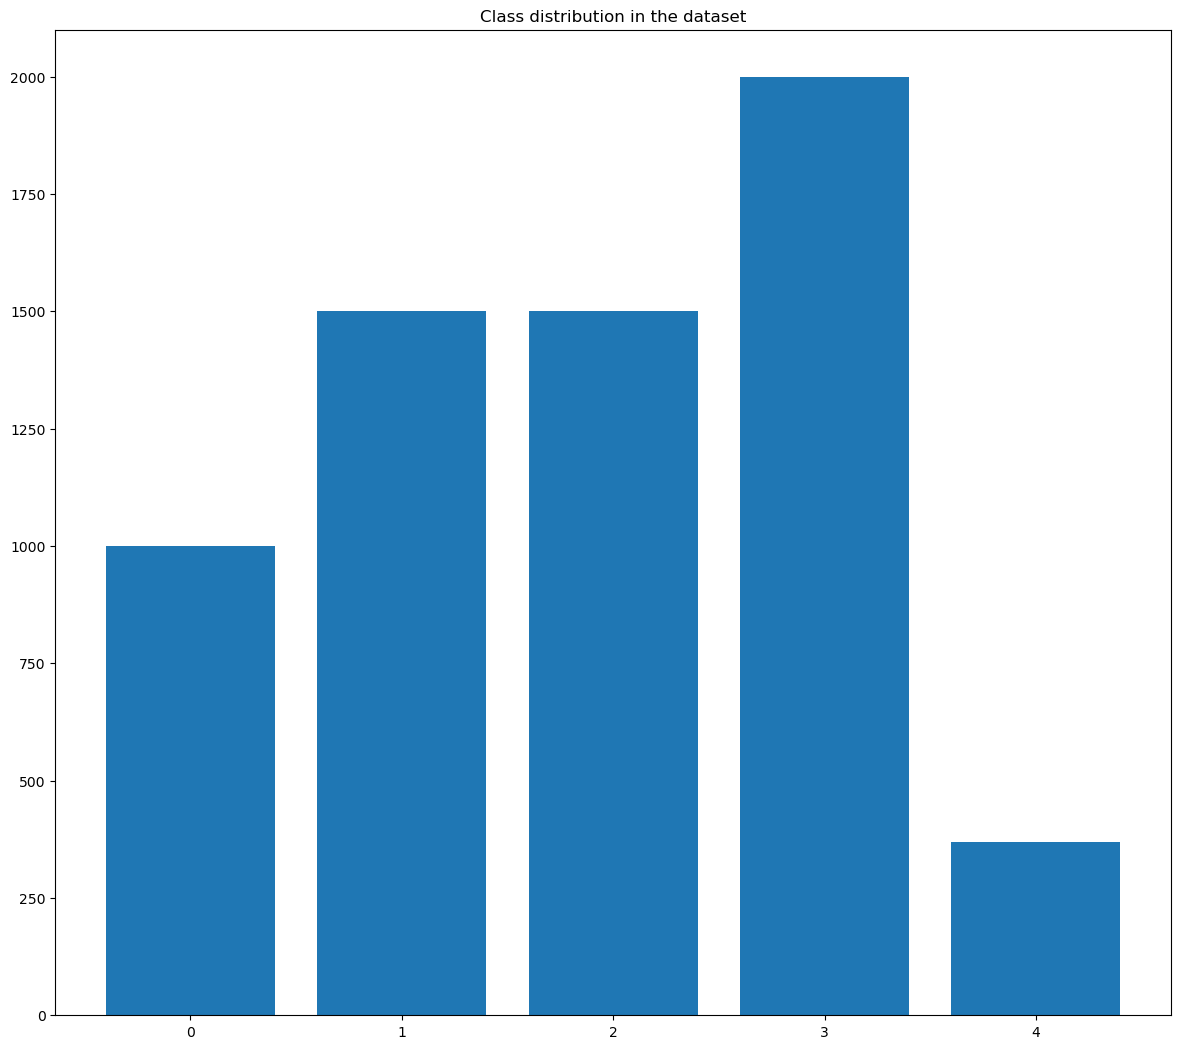

In [5]:
 # Counting the number of elements for each class
elemements_for_class = torch.unique(torch.IntTensor(full_train_dataset.targets), return_counts=True)[1]

print("Classes: ", full_train_dataset.classes)
print("Elements for class: ", elemements_for_class)
print("Images shape: ", full_train_dataset[0][0].shape)

plt.bar(full_train_dataset.classes, elemements_for_class) # Plotting the class distribution
plt.title('Class distribution in the dataset') # Adding title to the plot

plt.show()

Let's show an image for each class.

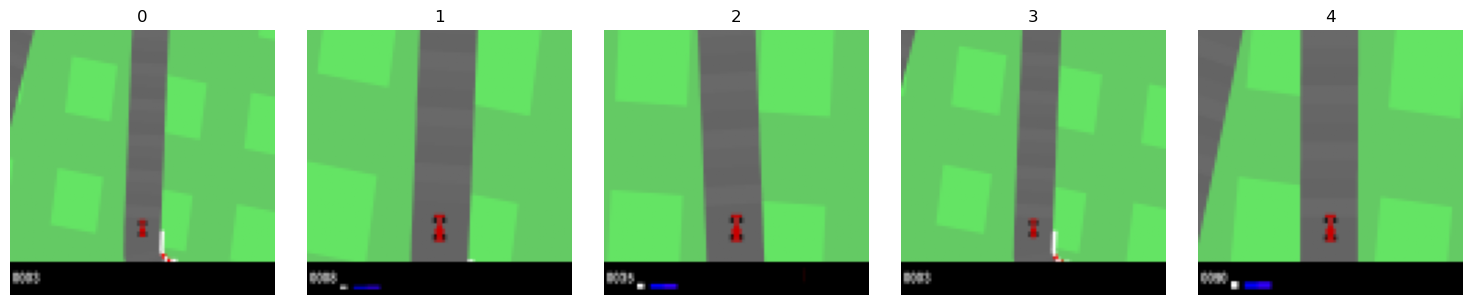

In [4]:
fig, axs = plt.subplots(1, 5, figsize=(15, 3))  # Create a figure containing 5 subplots
printed_classes = set()  # Set of printed classes

for image, label in train_dataset:
    if label not in printed_classes:
        axs[len(printed_classes)].imshow(image.permute(1, 2, 0))  # Show the image
        axs[len(printed_classes)].set_title(label)  # Set the title of the subplot
        axs[len(printed_classes)].axis('off')  # Disable the axis
        printed_classes.add(label) # Add the class to the set of printed classes

    if len(printed_classes) == 5:  # If all the classes have been printed break
        break

plt.tight_layout()  # Make the subplots fit in the figure properly
plt.show() 

The class 3 has 2000 elements, so we are going to check how many elements we need to add to the other classes to balance the dataset. We are going to make a Data Augmentation to balance the dataset. We are going to use the `torchvision.transforms` library to make the Data Augmentation. We are going to use the `RandomRotation` to make the Data Augmentation.

In [122]:
# Dictionary to store class counts
keys = [0, 1, 2, 3, 4]
values = elemements_for_class.tolist()


class_counts = { k:v for (k,v) in zip(keys, values)}  # Dictionary to store class counts 

# Define data transformations for data augmentation
augmentation_transform = transforms.Compose([
    transforms.RandomCrop(64, padding=4),
    # original dimension = 96x96x3
    transforms.Resize((96, 96)),
])

# Create an empty list to store augmented datasets for each class
augmented_datasets = []

# Iterate over classes
for class_idx in range(5):
    
    print("Iterating over class: ", class_idx)

    # Calculate the number of additional samples needed
    num_additional_samples = 2000 - class_counts[class_idx]

    # Create an additional dataset with augmented samples for the current class
    augmented_samples = []
    
    class_dataset = [sample for sample in train_dataset if sample[1] == class_idx]

    for i in range(num_additional_samples):
        # Randomly select an image from the original class dataset
        image, label = class_dataset[random.randint(0, len(class_dataset) - 1)]

        # Apply data augmentation
        augmented_image = augmentation_transform(image)

        # Append the augmented sample to the list
        augmented_samples.append((augmented_image, label))

    # Update class counts
    class_counts[class_idx] += num_additional_samples

    # Concatenate the original and additional datasets
    augmented_datasets.extend(augmented_samples)

# Combine the original and augmented datasets
augmented_dataset = torch.utils.data.ConcatDataset([train_dataset, augmented_datasets])


Iterating over class:  0
Iterating over class:  1
Iterating over class:  2
Iterating over class:  3
Iterating over class:  4


Let's check if the dataset is balanced now.

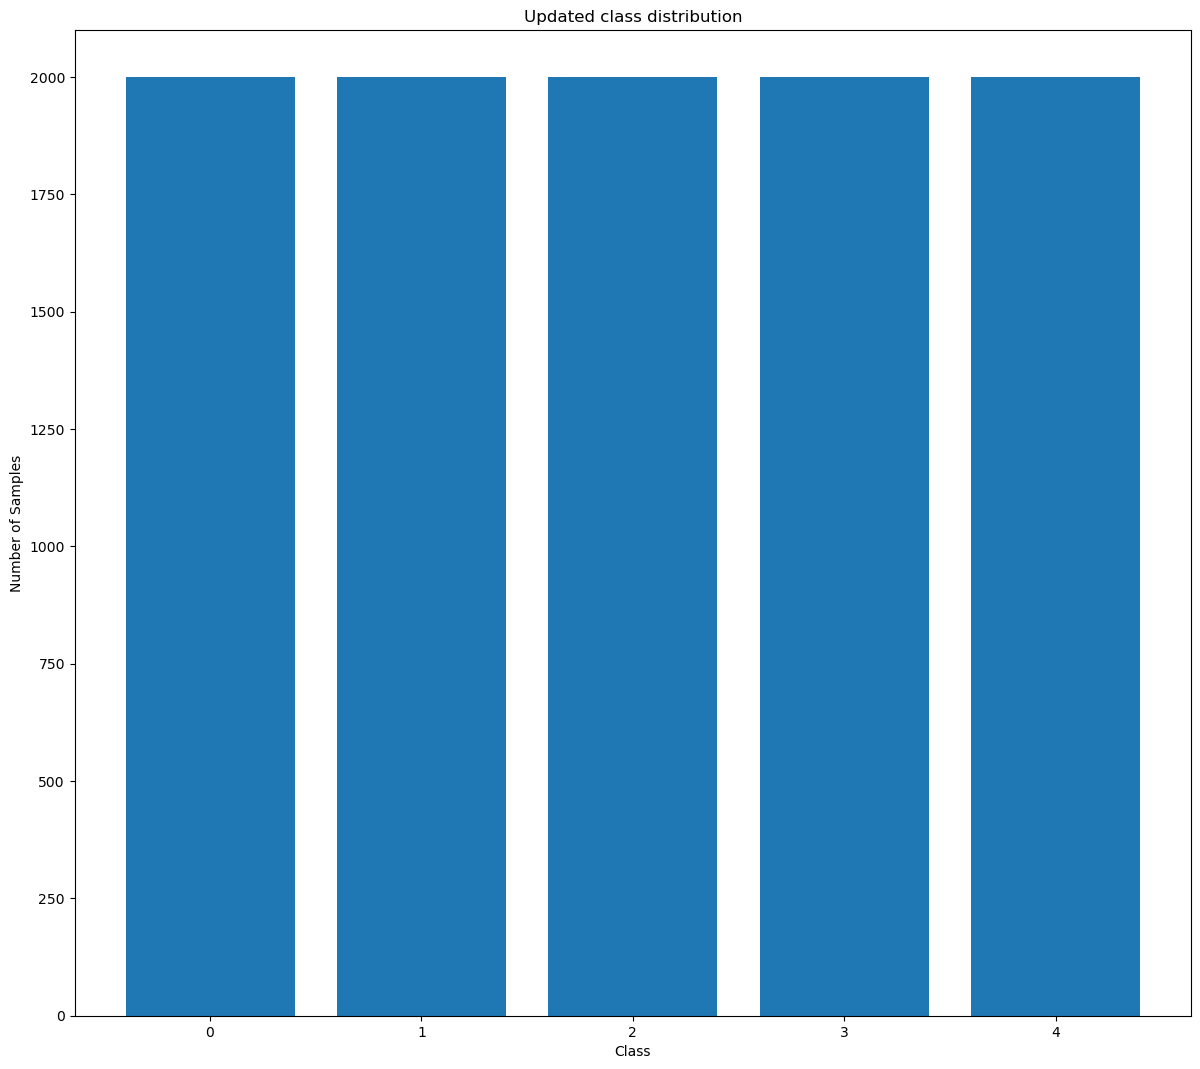

In [6]:
# Plot a bar chart of the updated class counts
class_labels, counts = zip(*class_counts.items()) # Unpack the dictionary into two lists
plt.bar(class_labels, counts)
plt.xlabel('Class')
plt.ylabel('Number of Samples')
plt.title('Updated class distribution')
plt.show()

We are going to create a Pytoch class rappresenting a CNN model. This class is going to be used to create the model and to train it.

Let's recap what a CNN is. A CNN is a neural network that is composed by convolutional layers. A convolutional layer is a layer that is used to extract features from an image. This is done by applying a filter to the image. The filter is a matrix of weights that is applied to to an image to extract features. For example if we have an RGB image and we apply a single kernel we will get in output a single image rappresenting a feature map.

After two convulational layers we are going to use a max pooling layer. This layer is used to reduce the dimensionality of the image. This is done by applying a filter to the image and taking the maximum value of the filter. This is done to reduce the number of parameters of the model and to reduce the computational cost of the model. Note that the kernel parameters usend in a CNN are learnable parameters, but this is not the case for the max pooling that is a fixed operation.

In [6]:
class SimpleCNN(nn.Module):
    
    def __init__(self):
        super(SimpleCNN, self).__init__()
        
        # INPUT IMAGE SIZE: 96x96x3
        # CONVOLUTION OUTPUT SIZE FORMULA: (W - K + 2P) / S + 1
        
        # First conv layer
        self.conv1 = nn.Conv2d(3, 64, kernel_size=5, stride=1, padding=2) # (96 - 5 + 2*2) / 1 + 1 = 96
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2) # (96 - 2) / 2 + 1 = 48

        # Calculate the output size after the first conv and pool layers

        # Second conv layer
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1) # (48 - 3 + 2*1) / 1 + 1 = 48
        # after applying pool: (48 - 2) / 2 + 1 = 24

        # Third conv layer
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1) # (24 - 3 + 2*1) / 1 + 1 = 24
        
        # after applying pool: (24 - 2) / 2 + 1 = 12

        # Fully connected layers
        self.fc1 = nn.Linear(256 * 12 * 12, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 5)  # 5 output classes

    def forward(self, x):
        # Convolutional layers
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))

        x = torch.flatten(x,1)

        # Fully connected layers
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)

        return x

In [7]:
class AdvancedCNN(nn.Module):
    
    def __init__(self):
        super(AdvancedCNN, self).__init__()
        
        # Convolutional layers
        self.conv1 = nn.Conv2d(3, 64, kernel_size=5, stride=1, padding=2)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout_conv = nn.Dropout2d(0.25)

        # Fully connected layers
        self.fc1 = nn.Linear(512 * 48 * 48, 1200)
        self.dropout_fc1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(1200, 600)
        self.dropout_fc2 = nn.Dropout(0.5)
        self.fc3 = nn.Linear(600, 84)
        self.fc4 = nn.Linear(84, 5)  # 5 output classes

    def forward(self, x):
        # Apply convolutional layers
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = self.dropout_conv(x)

        # Flatten the output for the fully connected layers
        x = torch.flatten(x, 1)

        # Apply fully connected layers
        x = F.relu(self.fc1(x))
        x = self.dropout_fc1(x)
        x = F.relu(self.fc2(x))
        x = self.dropout_fc2(x)
        x = F.relu(self.fc3(x))
        x = self.fc4(x)

        return x


Since we are using Pytorch we are going to instanciate a `torch.utils.data.DataLoader` object that is used to load the dataset in batches. This object is used to iterate over the dataset in batches and it is very useful when we have a large dataset.

In [8]:
def load_data(train_dataset, test_dataset, batch_size):
    train_loader = DataLoader(train_dataset, batch_size, shuffle=True)
    validation_loader = DataLoader(validation_dataset, batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size, shuffle=True)
    return train_loader, validation_loader, test_loader


Now that we have defined the model we are going to train it. To do this we are going to use the `train` function. This function is used to train the model for a given number of epochs. For each epoch we are going to iterate over the dataset and for each batch we are going to compute the loss and the accuracy of the model. After that we are going to compute the gradients and update the weights of the model.

Since we want to track the performance of the model during the training we are going to track the loss and the accuracy both for the training and the validation set. This is useful to see if the model is overfitting or not. If the model is overfitting the training loss will decrease while the validation loss will increase. This is due to the fact that the model is learning the training set and it is not able to generalize to the validation set.

In [10]:
def train_model(model, train_loader, validation_loader, num_epochs, optimizer):
    
    # Initialize accuracy metrics
    accuracy_metric = torchmetrics.Accuracy(num_classes=5, task='multiclass').to(dml)
    validation_accuracy_metric = torchmetrics.Accuracy(num_classes=5, task='multiclass').to(dml)

    loss_history, accuracy_history = [], []
    validation_loss_history, validation_accuracy_history = [], []

    batch_number = 0

    print("Training...")
    
    for epoch in range(num_epochs):
        model.train()  # Set the model to training mode

        for inputs, labels in train_loader:
            
            batch_number += 1;
            if (batch_number % 8 == 0): print("Batch number: ", batch_number, "/", len(train_loader))
            
            inputs, labels = inputs.to(dml), labels.to(dml)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = F.cross_entropy(outputs, labels)
            loss.backward()
            optimizer.step()
            
            accuracy_metric.update(outputs, labels) # Update accuracy metric on every batch
            accuracy_history.append(accuracy_metric.compute().item())

            loss_history.append(loss.item())        

        # Validation phase
        model.eval()  # Set the model to evaluation mode
        
        with torch.no_grad():
            for inputs, labels in validation_loader:
                inputs, labels = inputs.to(dml), labels.to(dml)
                outputs = model(inputs)
                
                validation_accuracy_metric.update(outputs, labels)
                validation_accuracy_history.append(validation_accuracy_metric.compute().item())
                
                loss = F.cross_entropy(outputs, labels)
                validation_loss_history.append(loss.item())
                        

        print(f"Epoch {epoch + 1}, Training Loss: {loss_history[-1]}, Validation Loss: {validation_loss_history[-1]}")
        print(f"Epoch {epoch + 1}, Training Accuracy: {accuracy_history[-1]}, Validation Accuracy: {validation_accuracy_history[-1]}")

    return loss_history, accuracy_history, validation_loss_history, validation_accuracy_history


In [11]:
def test_model(model, test_loader, device=dml):
    
    # Inizialize metrics
    accuracy_metric = torchmetrics.Accuracy(num_classes=5, task='multiclass').to(device)
    precision_metric = torchmetrics.Precision(num_classes=5, average='weighted', task='multiclass').to(device)
    recall_metric = torchmetrics.Recall(num_classes=5, average='weighted', task='multiclass').to(device)
    f1_metric = torchmetrics.F1Score(num_classes=5, average='weighted', task='multiclass').to(device)
    confusion_matrix_metric = torchmetrics.ConfusionMatrix(num_classes=5, task='multiclass').to(device)

    batch_number = 0;

    print("Testing...")

    model.eval()  # Imposta il modello in modalità di valutazione
    with torch.no_grad():  # Disabilita il tracciamento dei gradienti
        for data in test_loader:
                        
            batch_number += 1;
            if (batch_number % 8 == 0): print("Batch number: ", batch_number, "/", len(test_loader))
            
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)

            # Aggiorna le metriche
            accuracy_metric.update(outputs, labels)
            precision_metric.update(outputs, labels)
            recall_metric.update(outputs, labels)
            f1_metric.update(outputs, labels)
            confusion_matrix_metric.update(outputs, labels)

    # Calcola le metriche finali
    test_accuracy = accuracy_metric.compute().item()
    test_precision = precision_metric.compute().item()
    test_recall = recall_metric.compute().item()
    test_f1 = f1_metric.compute().item()
    confusion_matrix = confusion_matrix_metric.compute().cpu().numpy()
    
    print(f"Accuracy: {test_accuracy * 100}%")
    print(f"Precision: {test_precision * 100}%")
    print(f"Recall: {test_recall * 100}%")
    print(f"F1 Score: {test_f1 * 100}%")
    print("Confusion Matrix:\n", confusion_matrix)

    # Restituisce solo i valori finali
    return test_accuracy, test_precision, test_recall, test_f1, confusion_matrix

In [12]:
def plot_metrics(loss_history, validation_loss_history, accuracy_history, validation_accuracy_history, confusion_matrix):
    # Imposta una griglia di subplot con 4 grafici (2x2)
    fig, axs = plt.subplots(2, 2)

    # Grafico della training loss
    axs[0, 0].plot(range(1, len(loss_history) + 1), loss_history, 'r', label='Training Loss')
    axs[0, 0].set_title('Training Loss')
    axs[0, 0].set_xlabel('Batches')
    axs[0, 0].set_ylabel('Loss')
    axs[0, 0].legend()

    # Grafico della validation loss
    axs[0, 1].plot(range(1, len(validation_loss_history) + 1), validation_loss_history, 'b', label='Validation Loss')
    axs[0, 1].set_title('Validation Loss')
    axs[0, 1].set_xlabel('Batches')
    axs[0, 1].set_ylabel('Loss')
    axs[0, 1].legend()

    # Grafico della training accuracy
    axs[1, 0].plot(range(1, len(accuracy_history) + 1), accuracy_history, 'g', label='Training Accuracy')
    axs[1, 0].set_title('Training Accuracy')
    axs[1, 0].set_xlabel('Batches')
    axs[1, 0].set_ylabel('Accuracy')
    axs[1, 0].legend()

    # Grafico della validation accuracy
    axs[1, 1].plot(range(1, len(validation_accuracy_history) + 1), validation_accuracy_history, 'm', label='Validation Accuracy')
    axs[1, 1].set_title('Validation Accuracy')
    axs[1, 1].set_xlabel('Batches')
    axs[1, 1].set_ylabel('Accuracy')
    axs[1, 1].legend()

    plt.tight_layout()
    plt.show()

    im = plt.imshow(confusion_matrix, interpolation='nearest', cmap=plt.cm.Blues)
    plt.colorbar(im)
    tick_marks = np.arange(confusion_matrix.shape[0])
    plt.xticks(tick_marks, tick_marks)
    plt.yticks(tick_marks, tick_marks)
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('Confusion Matrix')

    # Aggiunta dei numeri di predizione in ogni casella
    for i in range(confusion_matrix.shape[0]):
        for j in range(confusion_matrix.shape[1]):
            plt.text(j, i, format(confusion_matrix[i, j], 'd'),
                    horizontalalignment='center',
                    color='white' if confusion_matrix[i, j] > confusion_matrix.max() / 2. else 'black')

    plt.show()

Let's train the SimpleCNN model making a grid search to find the best hyperparameters.


Training model number:  1
Epochs:  1  Batch size:  32  Learning rate:  0.001



Training...
Batch number:  8 / 160
Batch number:  16 / 160
Batch number:  24 / 160
Batch number:  32 / 160
Batch number:  40 / 160
Batch number:  48 / 160
Batch number:  56 / 160
Batch number:  64 / 160
Batch number:  72 / 160
Batch number:  80 / 160
Batch number:  88 / 160
Batch number:  96 / 160
Batch number:  104 / 160
Batch number:  112 / 160
Batch number:  120 / 160
Batch number:  128 / 160
Batch number:  136 / 160
Batch number:  144 / 160
Batch number:  152 / 160
Batch number:  160 / 160
Epoch 1, Training Loss: 1.1137058734893799, Validation Loss: 1.2228845357894897
Epoch 1, Training Accuracy: 0.47939562797546387, Validation Accuracy: 0.5600942969322205
Testing...
Batch number:  8 / 86
Batch number:  16 / 86
Batch number:  24 / 86
Batch number:  32 / 86
Batch number:  40 / 86
Batch number:  48 / 86
Batch number:  56 / 86
Batch number:  64 / 86
Batch number:  72 / 86
Batch number:  80 / 86
Accuracy: 62.931978702545166%
Precision: 69.09154653549194%
Recall: 62.93197274208069%
F1 Sc

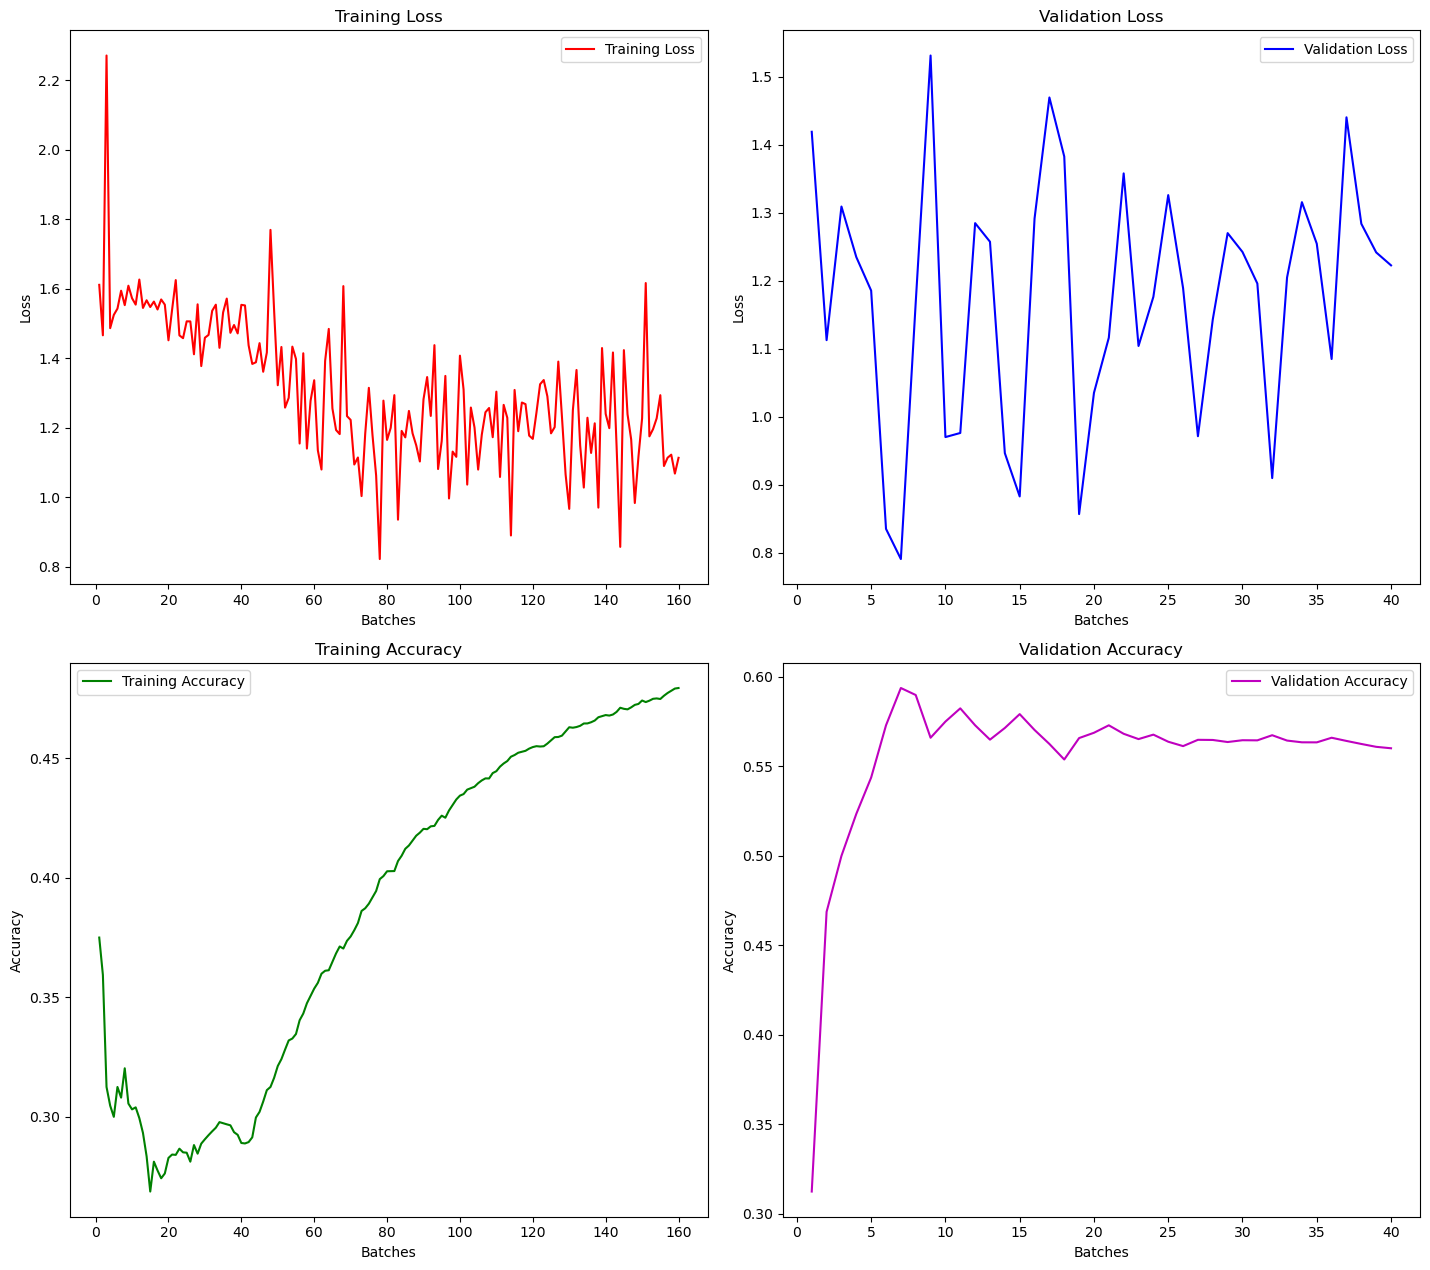

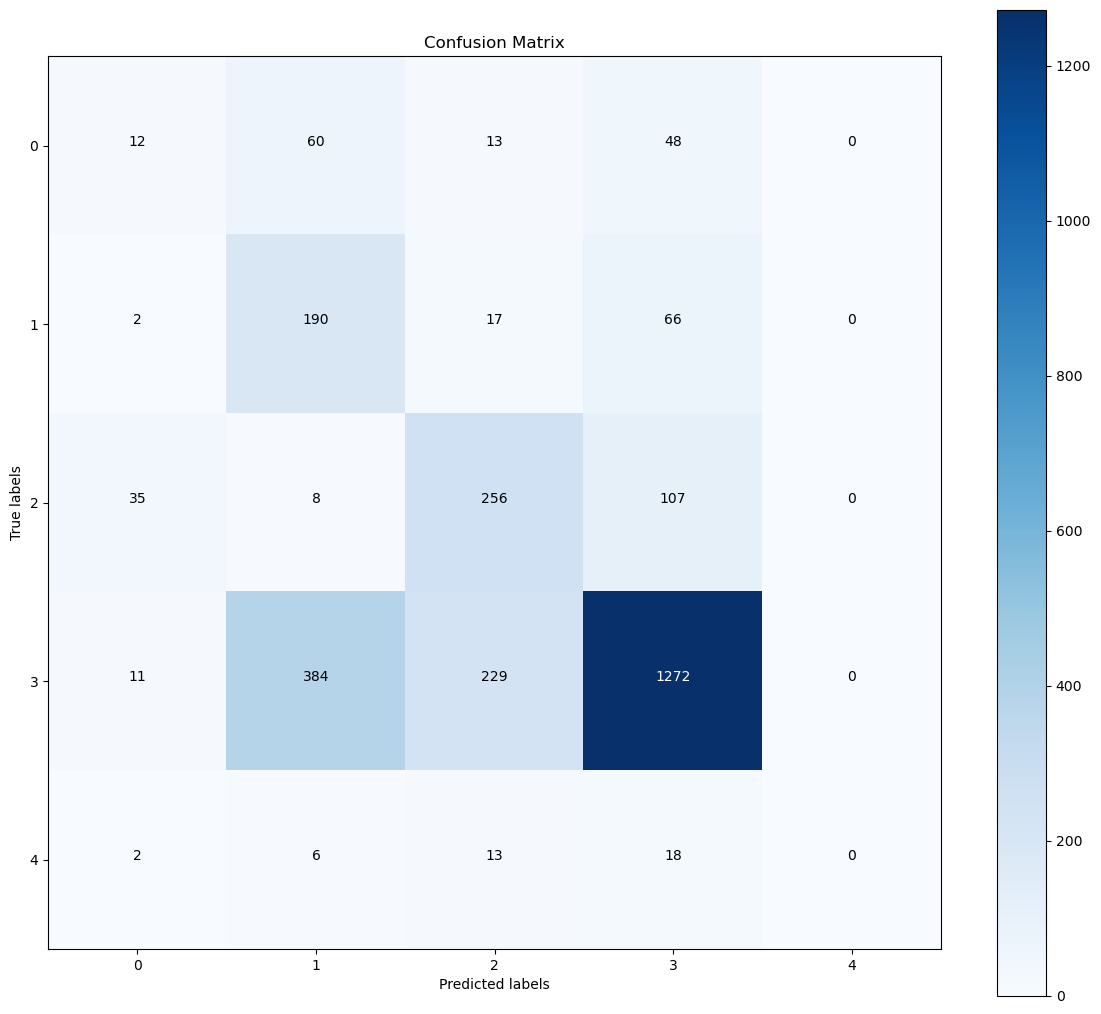


Training model number:  2
Epochs:  1  Batch size:  32  Learning rate:  0.0001

Training...
Batch number:  8 / 160
Batch number:  16 / 160
Batch number:  24 / 160
Batch number:  32 / 160
Batch number:  40 / 160
Batch number:  48 / 160
Batch number:  56 / 160
Batch number:  64 / 160
Batch number:  72 / 160
Batch number:  80 / 160
Batch number:  88 / 160
Batch number:  96 / 160
Batch number:  104 / 160
Batch number:  112 / 160
Batch number:  120 / 160
Batch number:  128 / 160
Batch number:  136 / 160
Batch number:  144 / 160
Batch number:  152 / 160
Batch number:  160 / 160
Epoch 1, Training Loss: 0.785936713218689, Validation Loss: 1.352569341659546
Epoch 1, Training Accuracy: 0.4670329689979553, Validation Accuracy: 0.5522388219833374
Testing...
Batch number:  8 / 86
Batch number:  16 / 86
Batch number:  24 / 86
Batch number:  32 / 86
Batch number:  40 / 86
Batch number:  48 / 86
Batch number:  56 / 86
Batch number:  64 / 86
Batch number:  72 / 86
Batch number:  80 / 86
Accuracy: 62.20

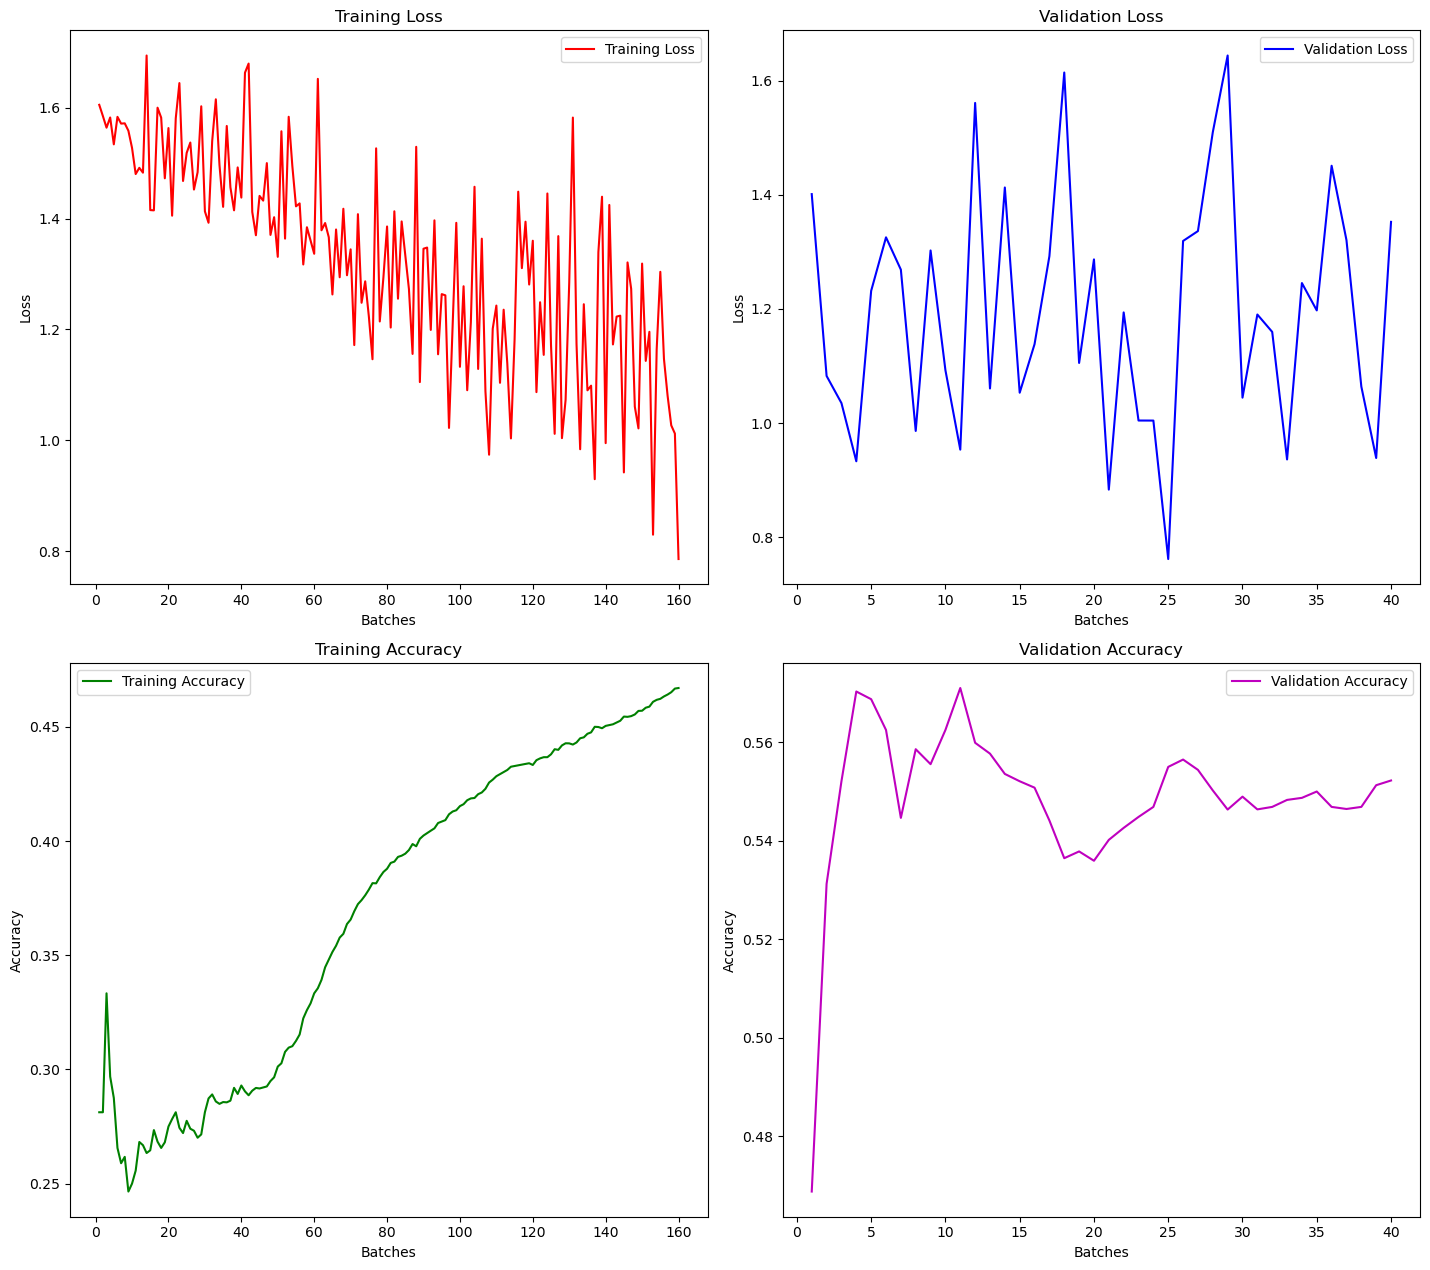

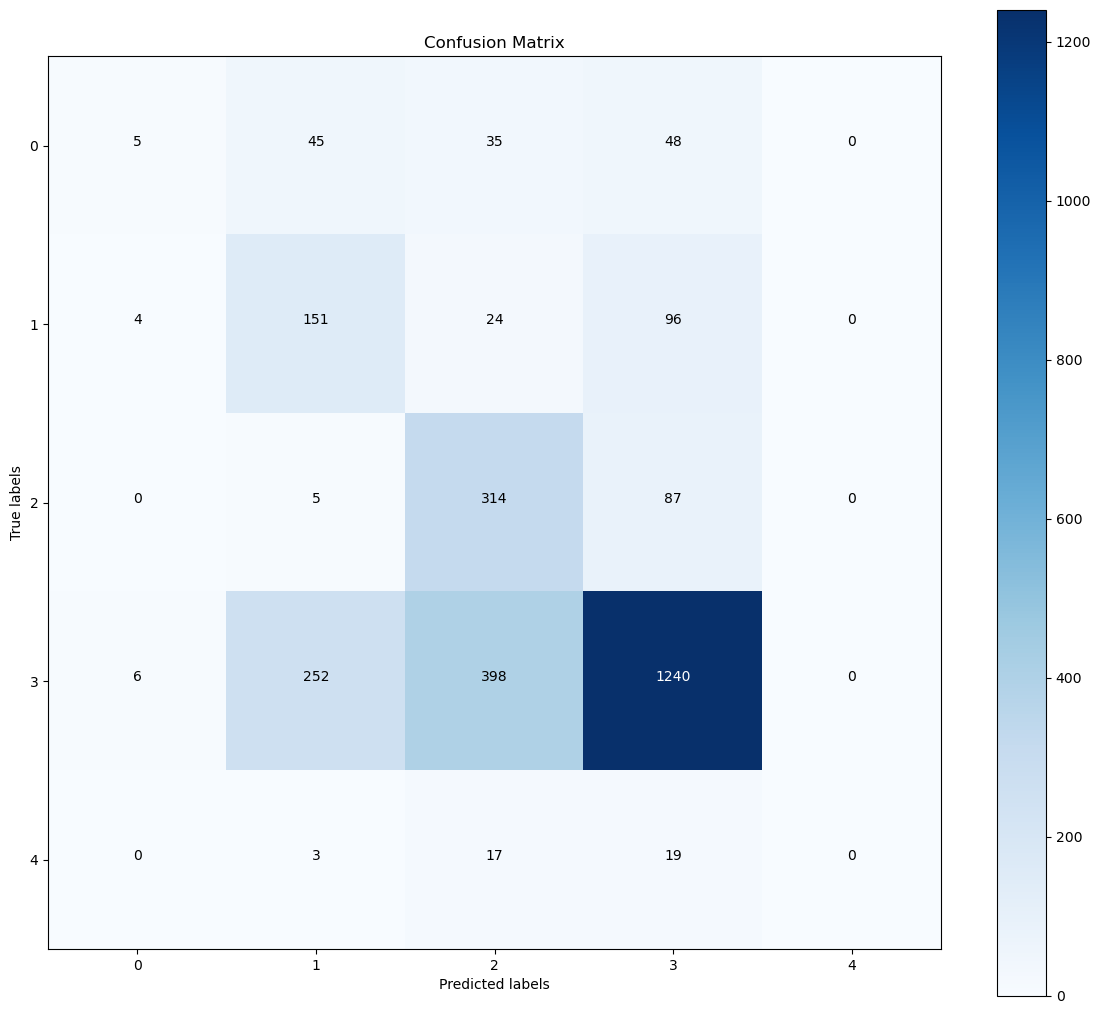


Training model number:  3
Epochs:  1  Batch size:  64  Learning rate:  0.001

Training...
Batch number:  8 / 80
Batch number:  16 / 80
Batch number:  24 / 80
Batch number:  32 / 80
Batch number:  40 / 80
Batch number:  48 / 80
Batch number:  56 / 80
Batch number:  64 / 80
Batch number:  72 / 80
Batch number:  80 / 80
Epoch 1, Training Loss: 1.0310897827148438, Validation Loss: 1.1112622022628784
Epoch 1, Training Accuracy: 0.49744898080825806, Validation Accuracy: 0.571091890335083
Testing...
Batch number:  8 / 43
Batch number:  16 / 43
Batch number:  24 / 43
Batch number:  32 / 43
Batch number:  40 / 43
Accuracy: 62.09530830383301%
Precision: 68.6819076538086%
Recall: 62.09530830383301%
F1 Score: 63.79559636116028%
Confusion Matrix:
 [[  28   44   13   48    0]
 [  11  176   18   70    0]
 [  39    5  259  103    0]
 [  42  328  282 1244    0]
 [   2    6   14   17    0]]


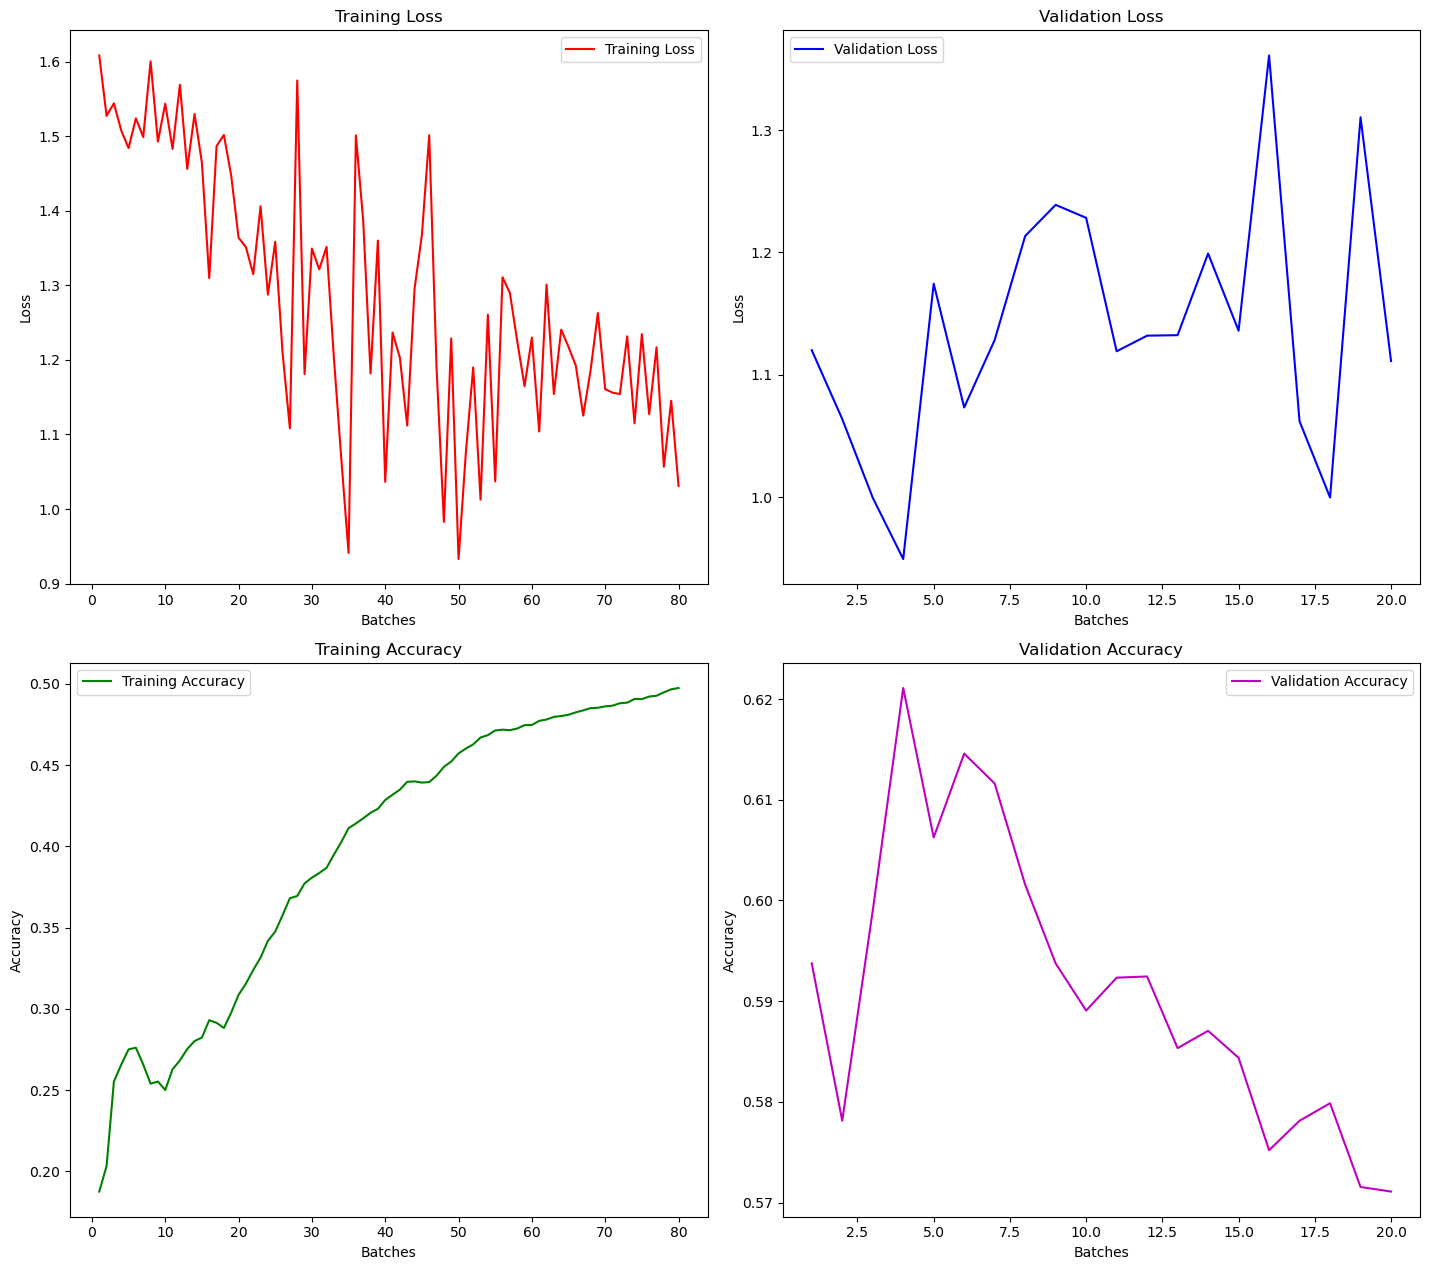

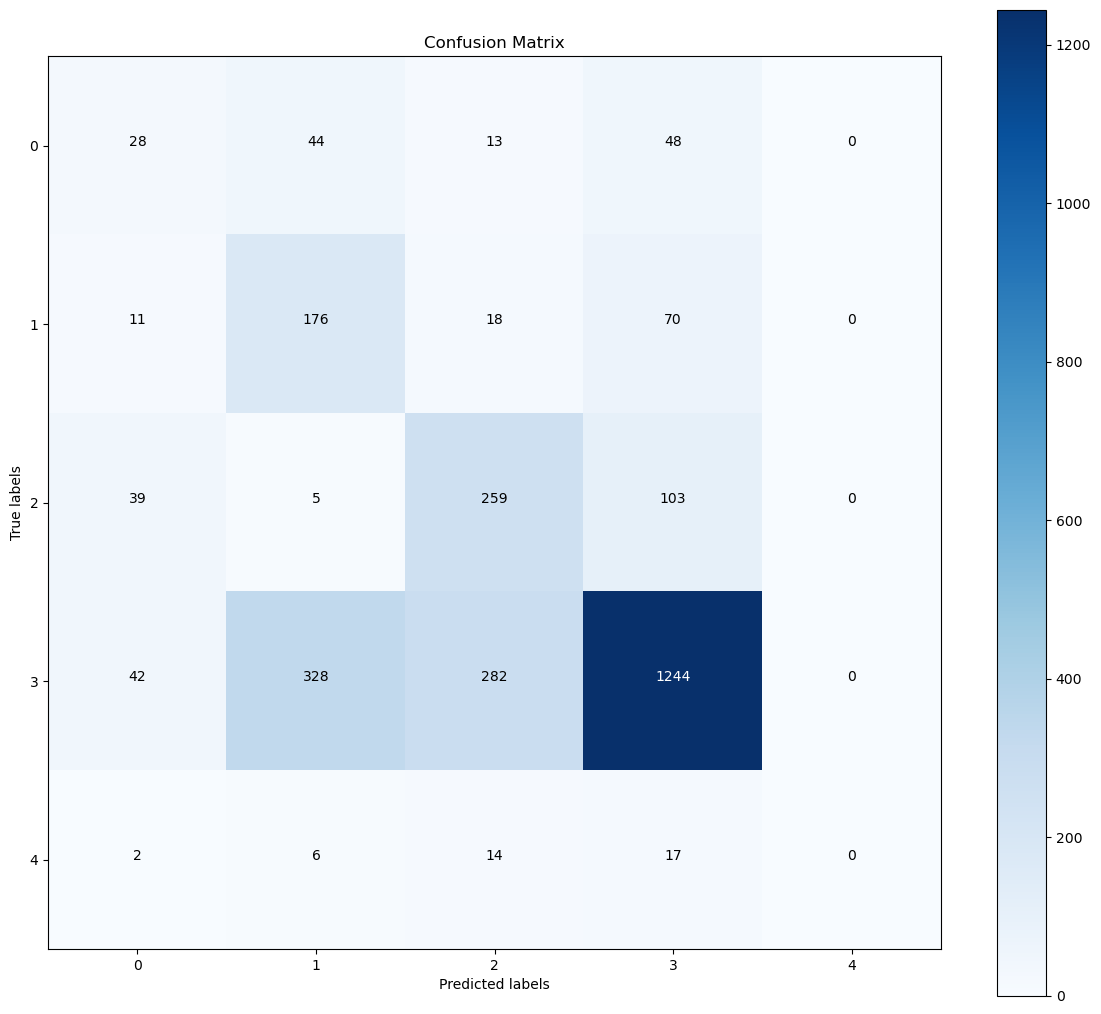


Training model number:  4
Epochs:  1  Batch size:  64  Learning rate:  0.0001

Training...
Batch number:  8 / 80
Batch number:  16 / 80
Batch number:  24 / 80
Batch number:  32 / 80
Batch number:  40 / 80
Batch number:  48 / 80
Batch number:  56 / 80
Batch number:  64 / 80
Batch number:  72 / 80
Batch number:  80 / 80
Epoch 1, Training Loss: 1.2178317308425903, Validation Loss: 1.2777172327041626
Epoch 1, Training Accuracy: 0.42111462354660034, Validation Accuracy: 0.533385694026947
Testing...
Batch number:  8 / 43
Batch number:  16 / 43
Batch number:  24 / 43
Batch number:  32 / 43
Batch number:  40 / 43
Accuracy: 60.05820631980896%
Precision: 67.15189218521118%
Recall: 60.05820631980896%
F1 Score: 60.925668478012085%
Confusion Matrix:
 [[   4   48   36   45    0]
 [   4  160   22   89    0]
 [   1    6  315   84    0]
 [  14  296  414 1172    0]
 [   0    4   17   18    0]]


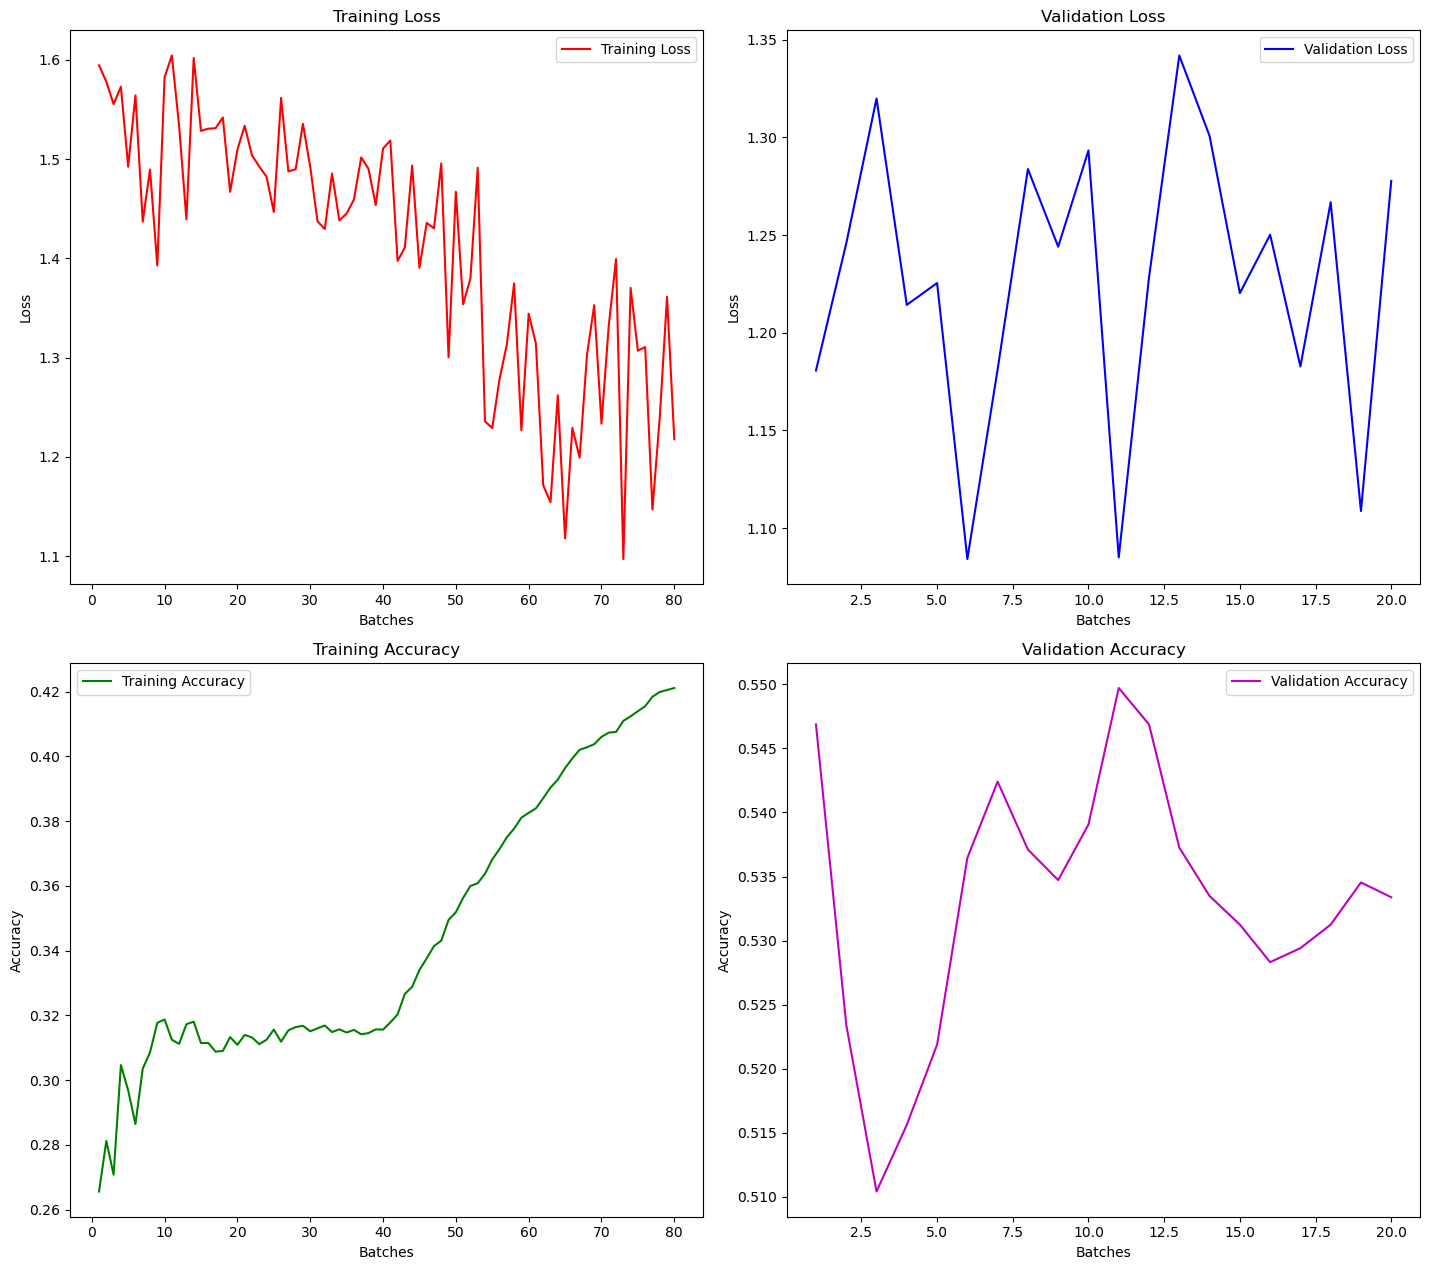

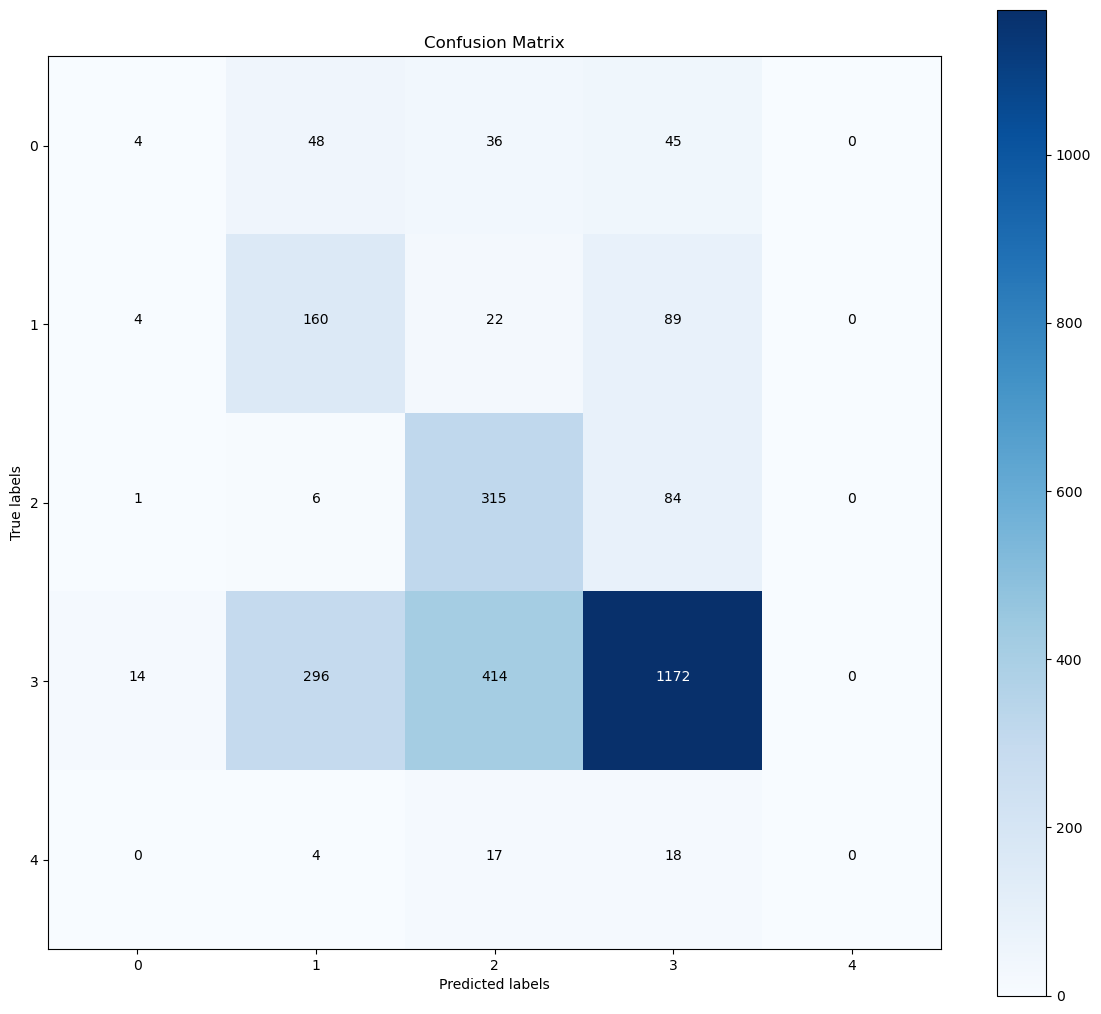


Training model number:  5
Epochs:  3  Batch size:  32  Learning rate:  0.001

Training...
Batch number:  8 / 160
Batch number:  16 / 160
Batch number:  24 / 160
Batch number:  32 / 160
Batch number:  40 / 160
Batch number:  48 / 160
Batch number:  56 / 160
Batch number:  64 / 160
Batch number:  72 / 160
Batch number:  80 / 160
Batch number:  88 / 160
Batch number:  96 / 160
Batch number:  104 / 160
Batch number:  112 / 160
Batch number:  120 / 160
Batch number:  128 / 160
Batch number:  136 / 160
Batch number:  144 / 160
Batch number:  152 / 160
Batch number:  160 / 160
Epoch 1, Training Loss: 0.776875376701355, Validation Loss: 1.3521989583969116
Epoch 1, Training Accuracy: 0.4415227770805359, Validation Accuracy: 0.5679497122764587
Batch number:  168 / 160
Batch number:  176 / 160
Batch number:  184 / 160
Batch number:  192 / 160
Batch number:  200 / 160
Batch number:  208 / 160
Batch number:  216 / 160
Batch number:  224 / 160
Batch number:  232 / 160
Batch number:  240 / 160
Batch

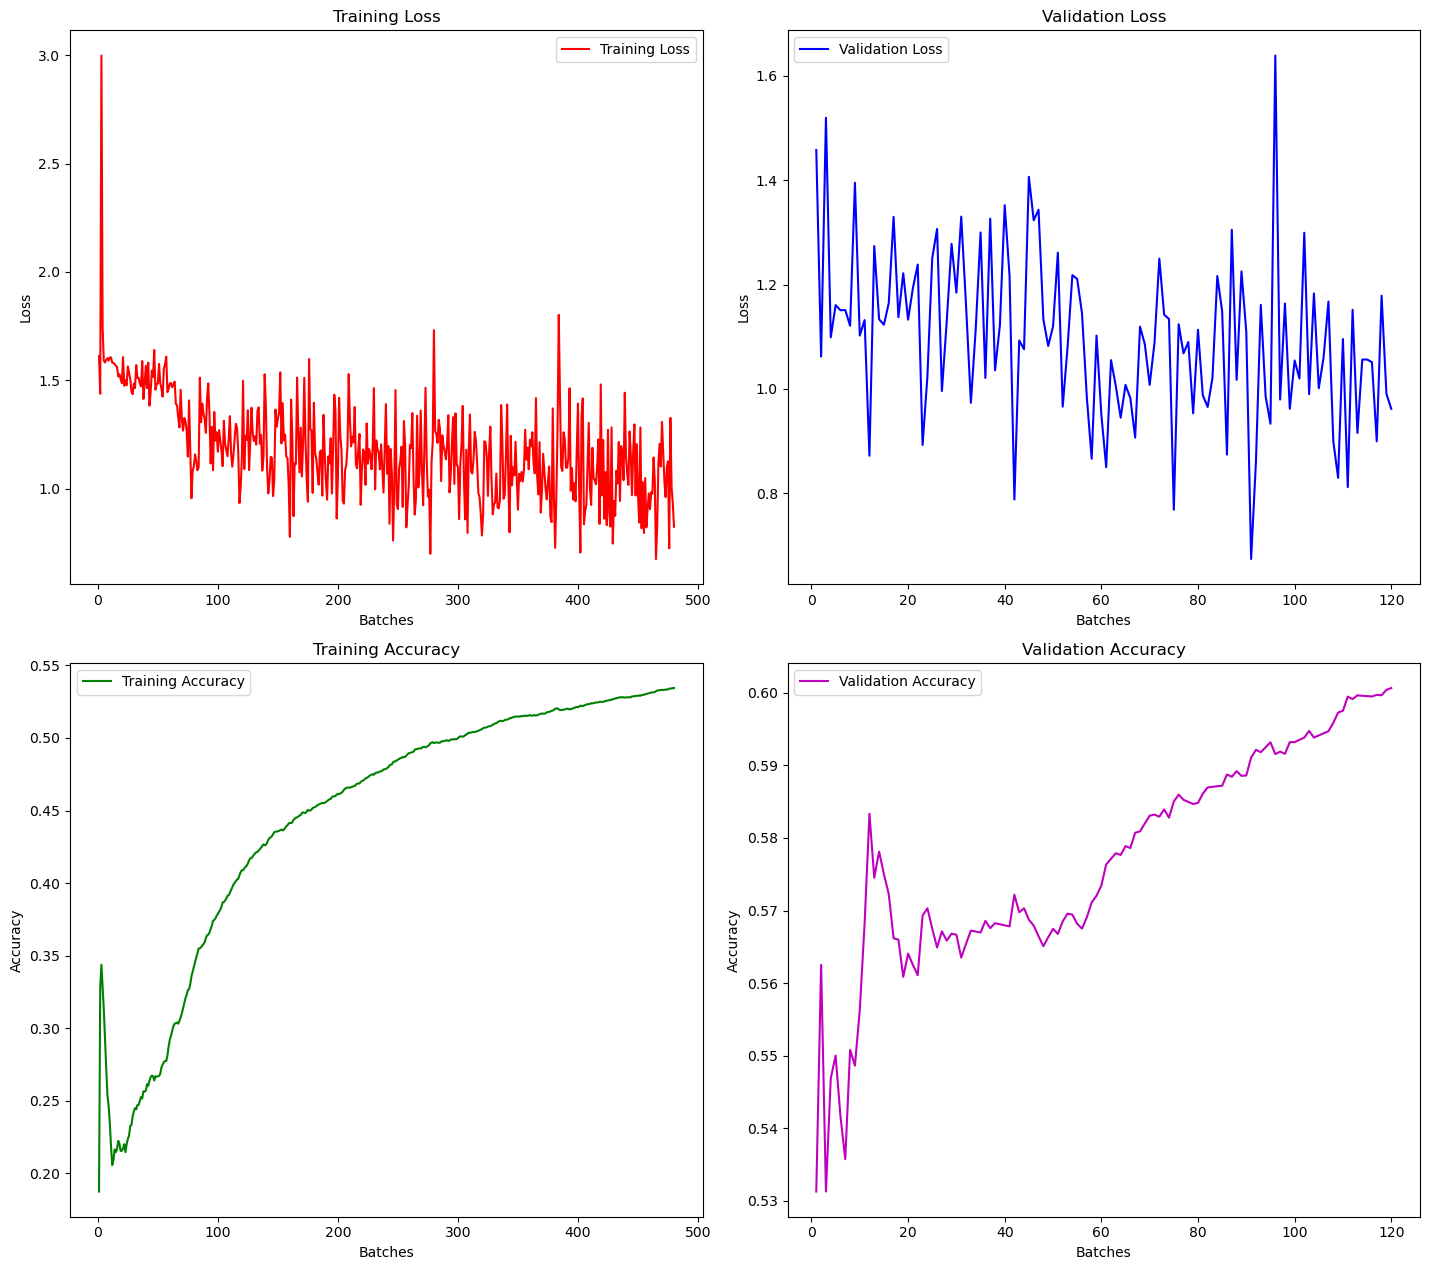

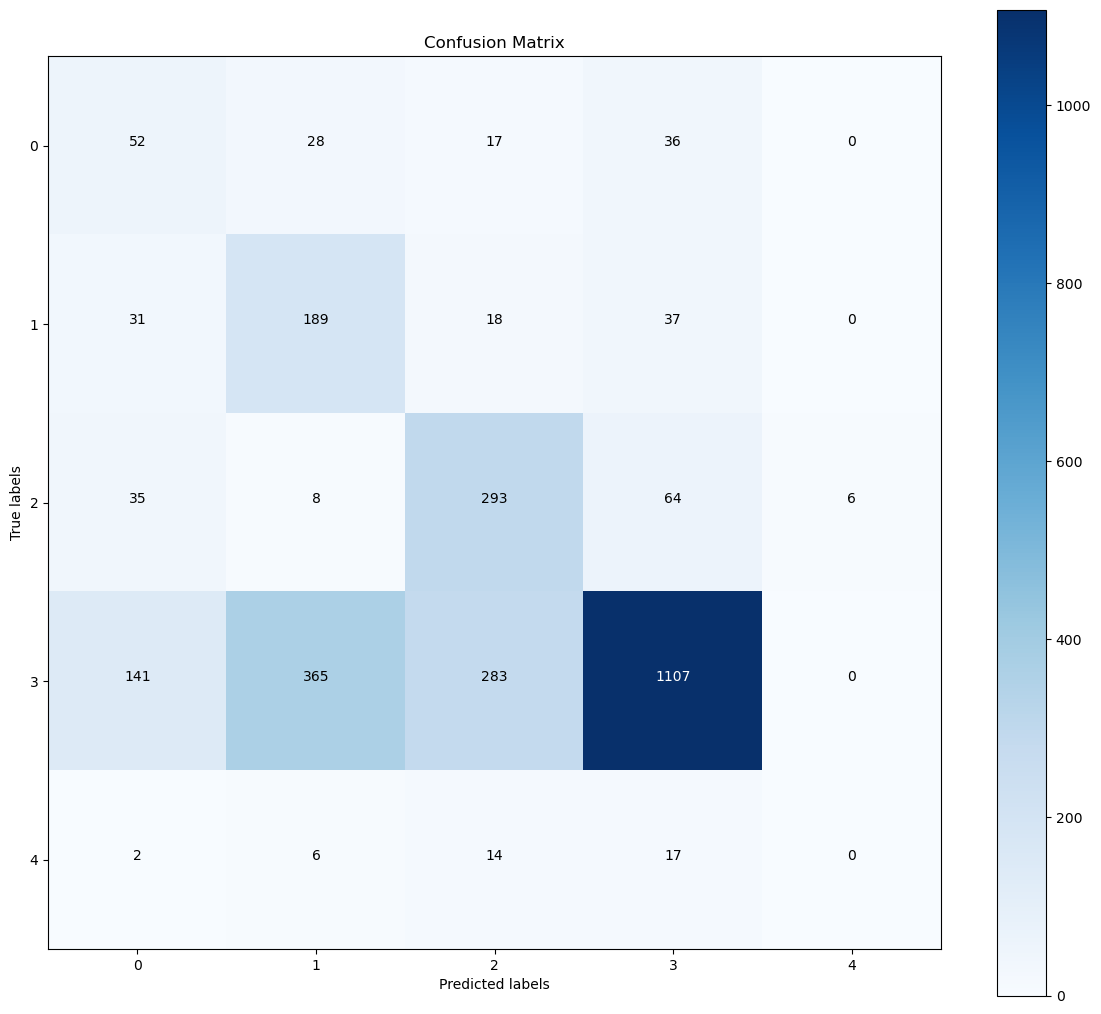


Training model number:  6
Epochs:  3  Batch size:  32  Learning rate:  0.0001

Training...
Batch number:  8 / 160
Batch number:  16 / 160
Batch number:  24 / 160
Batch number:  32 / 160
Batch number:  40 / 160
Batch number:  48 / 160
Batch number:  56 / 160
Batch number:  64 / 160
Batch number:  72 / 160
Batch number:  80 / 160
Batch number:  88 / 160
Batch number:  96 / 160
Batch number:  104 / 160
Batch number:  112 / 160
Batch number:  120 / 160
Batch number:  128 / 160
Batch number:  136 / 160
Batch number:  144 / 160
Batch number:  152 / 160
Batch number:  160 / 160
Epoch 1, Training Loss: 1.3506267070770264, Validation Loss: 1.4621444940567017
Epoch 1, Training Accuracy: 0.4750784933567047, Validation Accuracy: 0.5530243515968323
Batch number:  168 / 160
Batch number:  176 / 160
Batch number:  184 / 160
Batch number:  192 / 160
Batch number:  200 / 160
Batch number:  208 / 160
Batch number:  216 / 160
Batch number:  224 / 160
Batch number:  232 / 160
Batch number:  240 / 160
Bat

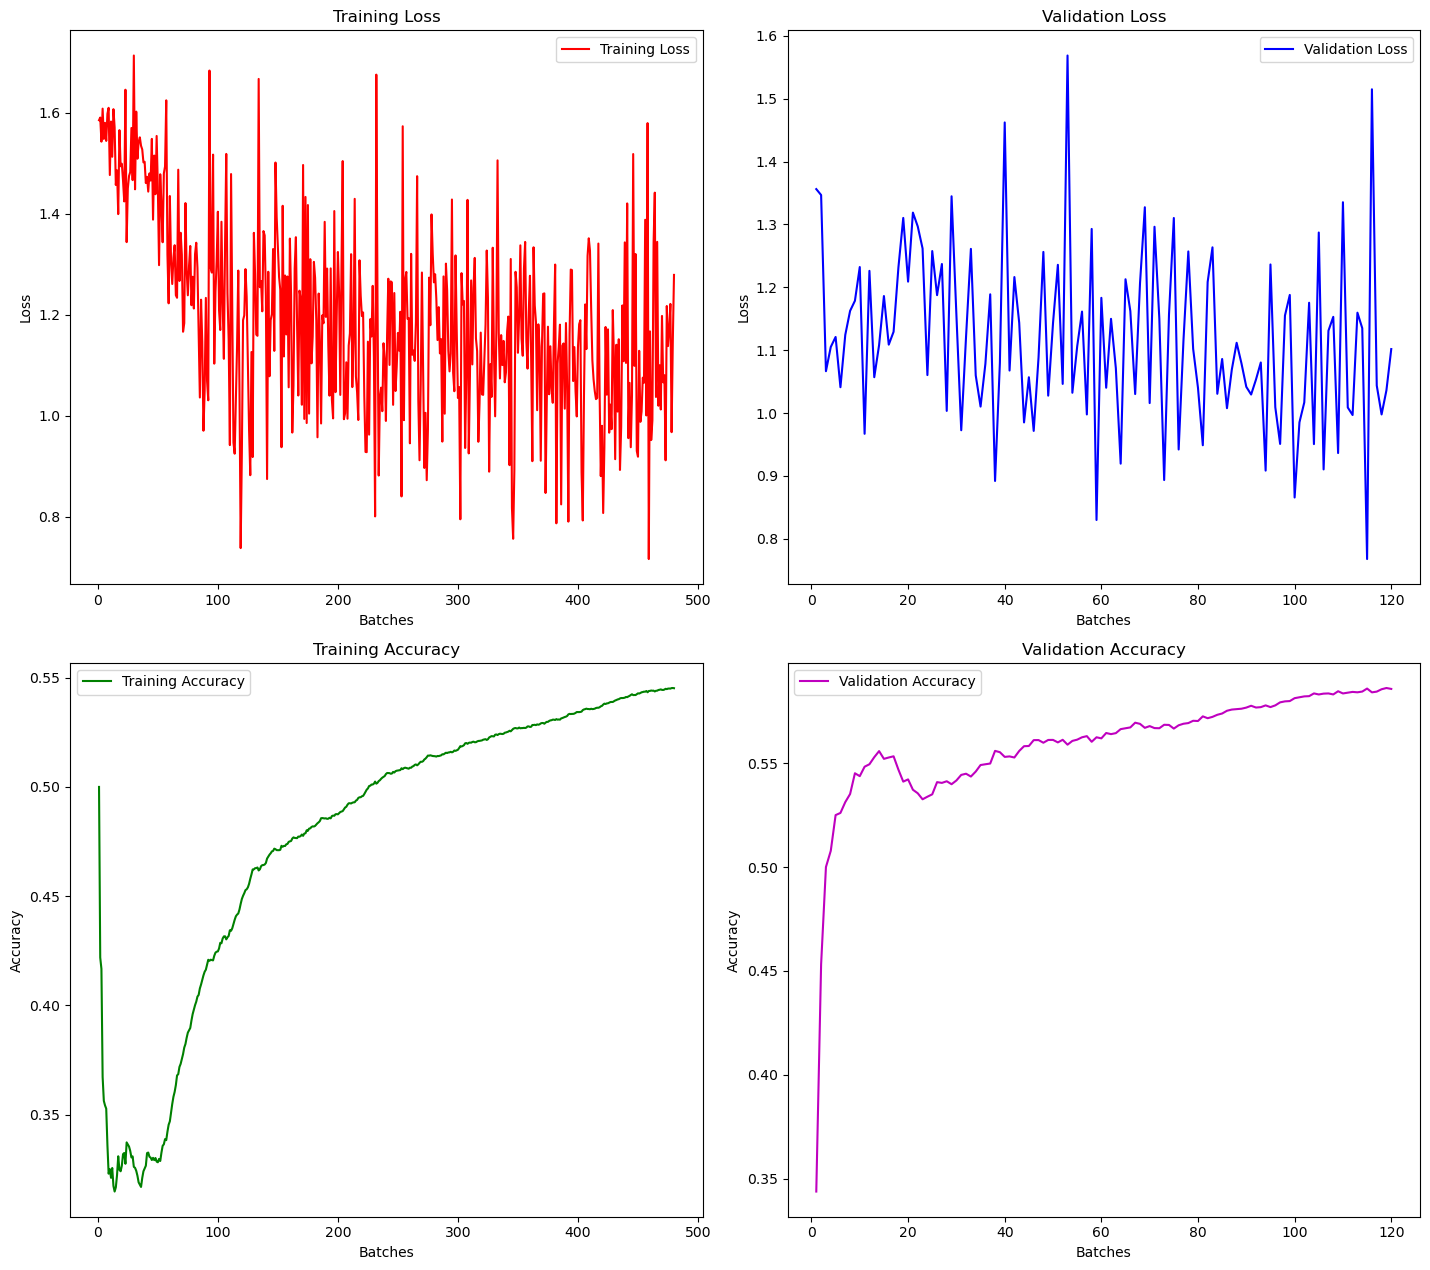

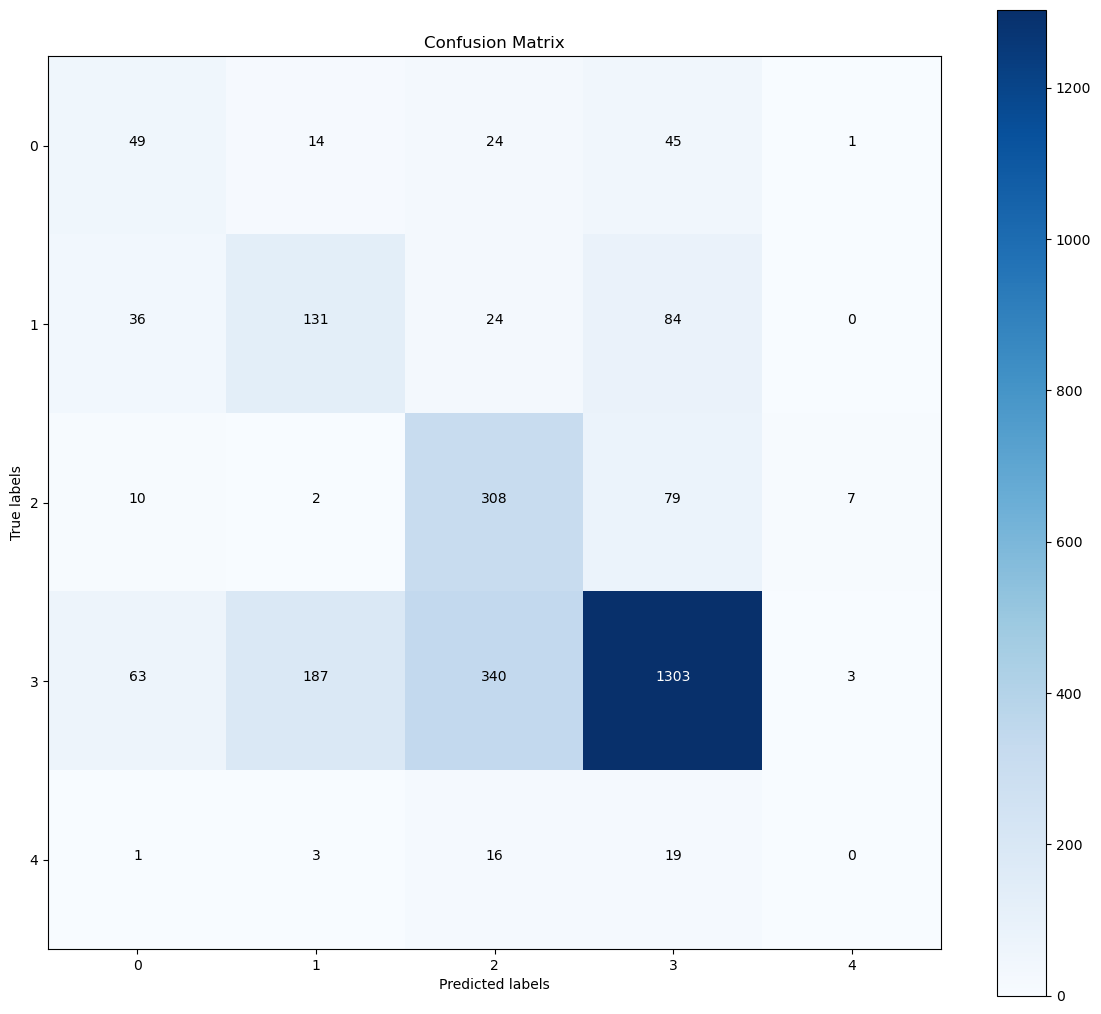


Training model number:  7
Epochs:  3  Batch size:  64  Learning rate:  0.001

Training...
Batch number:  8 / 80
Batch number:  16 / 80
Batch number:  24 / 80
Batch number:  32 / 80
Batch number:  40 / 80
Batch number:  48 / 80
Batch number:  56 / 80
Batch number:  64 / 80
Batch number:  72 / 80
Batch number:  80 / 80
Epoch 1, Training Loss: 1.2504199743270874, Validation Loss: 1.473318099975586
Epoch 1, Training Accuracy: 0.43700942397117615, Validation Accuracy: 0.5435978174209595
Batch number:  88 / 80
Batch number:  96 / 80
Batch number:  104 / 80
Batch number:  112 / 80
Batch number:  120 / 80
Batch number:  128 / 80
Batch number:  136 / 80
Batch number:  144 / 80
Batch number:  152 / 80
Batch number:  160 / 80
Epoch 2, Training Loss: 1.2912185192108154, Validation Loss: 1.1775057315826416
Epoch 2, Training Accuracy: 0.5064756870269775, Validation Accuracy: 0.5683425068855286
Batch number:  168 / 80
Batch number:  176 / 80
Batch number:  184 / 80
Batch number:  192 / 80
Batch numb

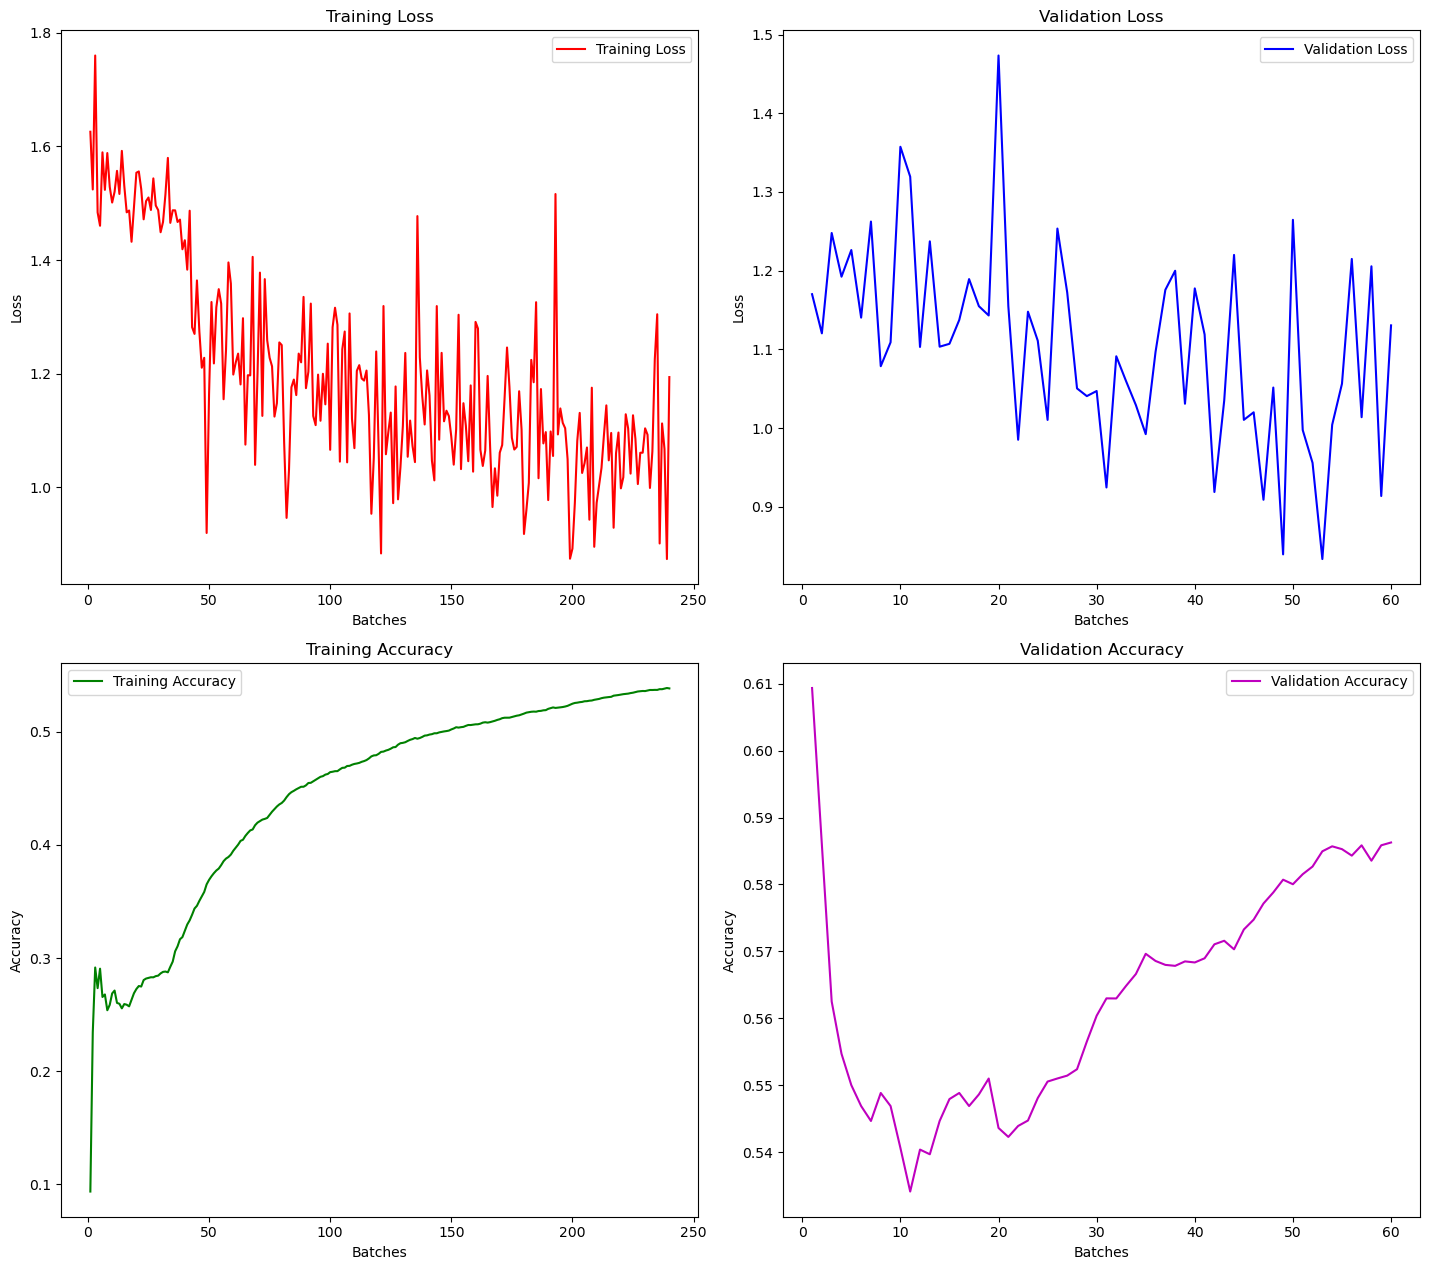

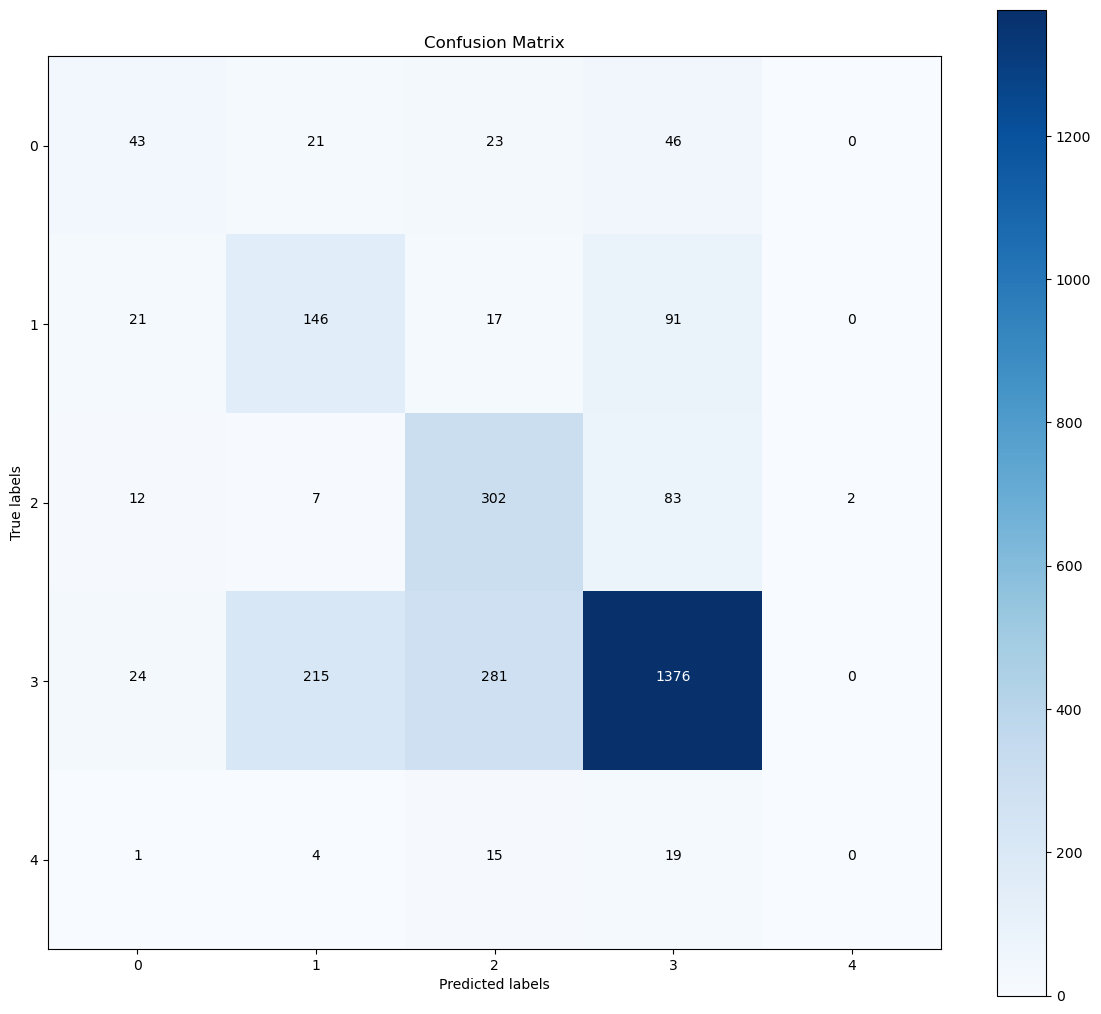


Training model number:  8
Epochs:  3  Batch size:  64  Learning rate:  0.0001

Training...
Batch number:  8 / 80
Batch number:  16 / 80
Batch number:  24 / 80
Batch number:  32 / 80
Batch number:  40 / 80
Batch number:  48 / 80
Batch number:  56 / 80
Batch number:  64 / 80
Batch number:  72 / 80
Batch number:  80 / 80
Epoch 1, Training Loss: 1.3054347038269043, Validation Loss: 1.3478083610534668
Epoch 1, Training Accuracy: 0.3897174298763275, Validation Accuracy: 0.5396701097488403
Batch number:  88 / 80
Batch number:  96 / 80
Batch number:  104 / 80
Batch number:  112 / 80
Batch number:  120 / 80
Batch number:  128 / 80
Batch number:  136 / 80
Batch number:  144 / 80
Batch number:  152 / 80
Batch number:  160 / 80
Epoch 2, Training Loss: 1.1316455602645874, Validation Loss: 1.1991965770721436
Epoch 2, Training Accuracy: 0.4761577844619751, Validation Accuracy: 0.5514532923698425
Batch number:  168 / 80
Batch number:  176 / 80
Batch number:  184 / 80
Batch number:  192 / 80
Batch num

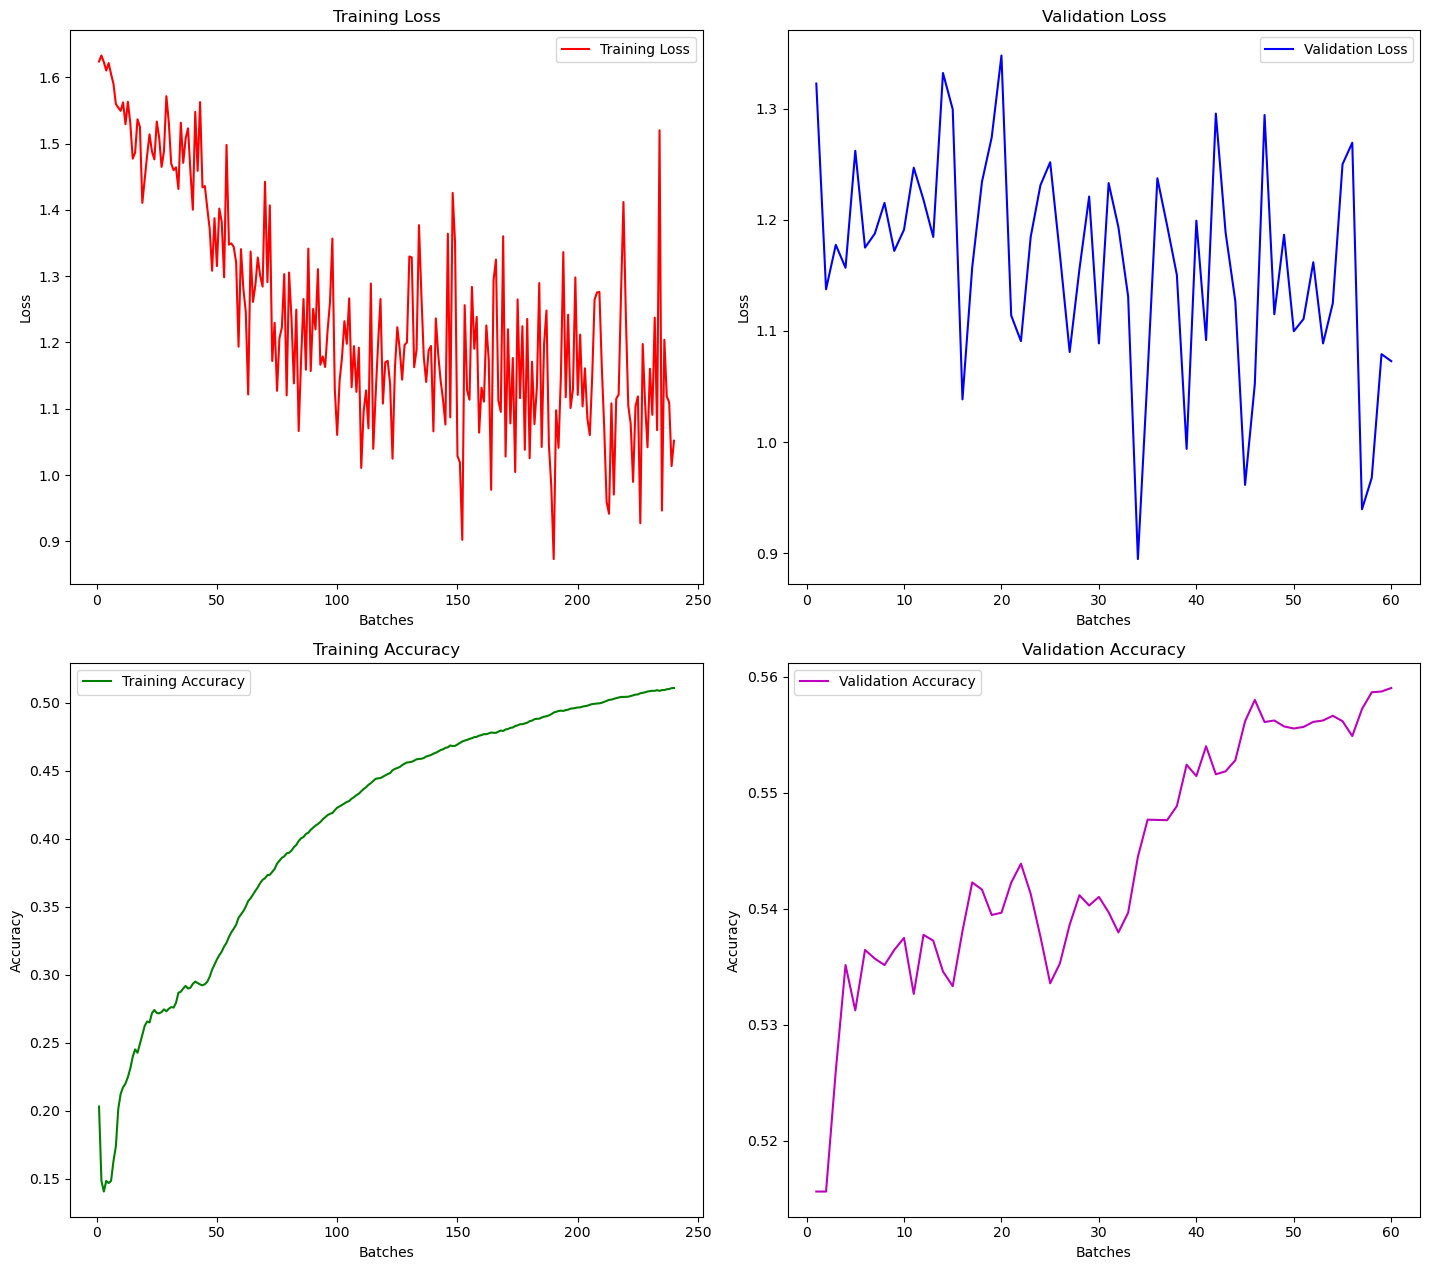

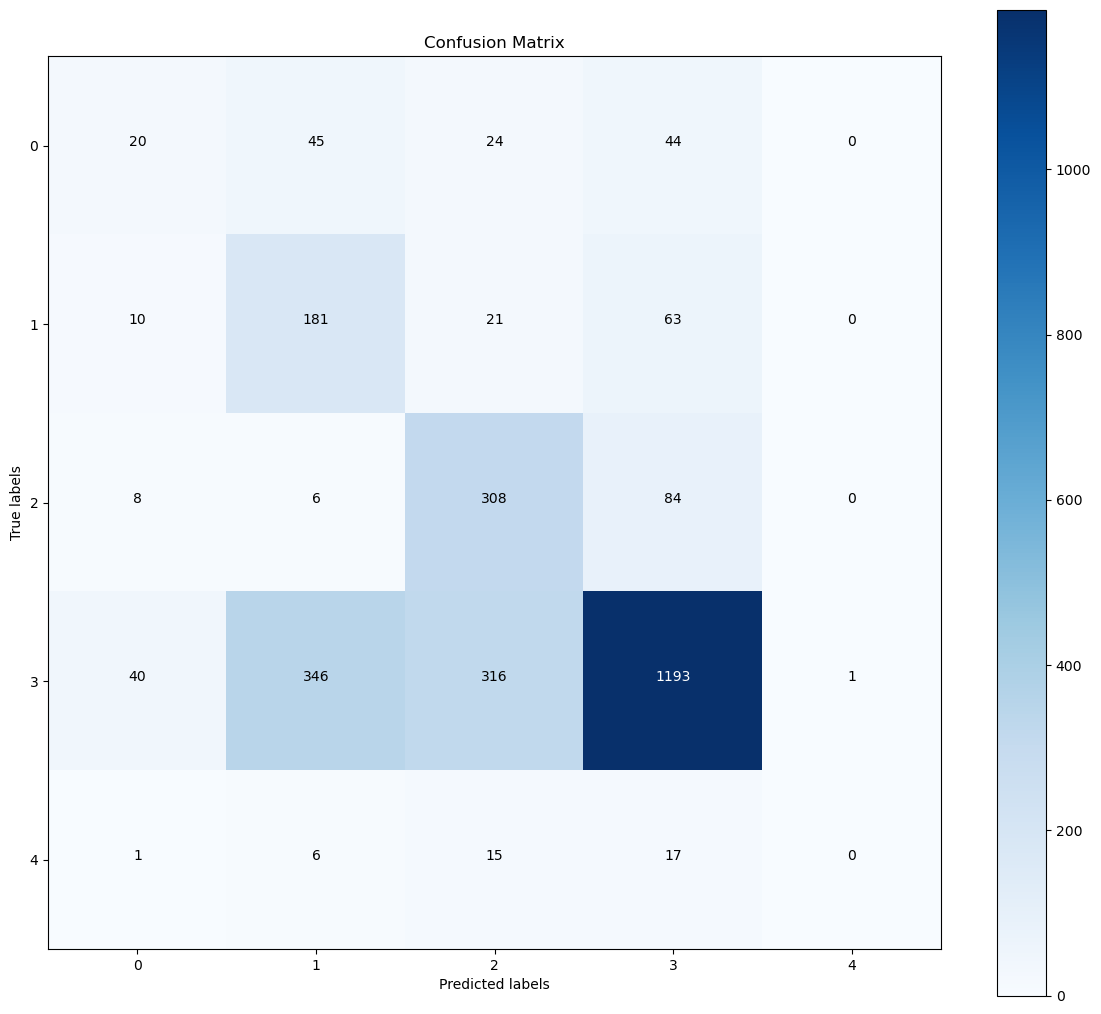

In [118]:
number_epochs = [1,3]
batch_sizes = [32,64]
learning_rates = [0.001, 0.0001]

model_number = 1

for epochs in number_epochs:
    for batch_size in batch_sizes:
        for learning_rate in learning_rates:
            
            print()
            print("Training model number: ", model_number)
            print("Epochs: ", epochs, " Batch size: ", batch_size, " Learning rate: ", learning_rate)
            print()
            
            model = SimpleCNN().to(dml)
            optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
            
            train_loader, validation_loader, test_loader = load_data(train_dataset, test_dataset, batch_size)
            
            loss_history, accuracy_history, validation_loss_history, validation_accuracy_history = train_model(model, train_loader, validation_loader, num_epochs=epochs, optimizer=optimizer)
            test_accuracy, test_precision, test_recall, test_f1, confusion_matrix = test_model(model, test_loader)
            
            plot_metrics(loss_history, validation_loss_history, accuracy_history, validation_accuracy_history, confusion_matrix)
            model_number += 1
            

Let's train the AdvancedCNN model making a grid search to find the best hyperparameters.

In [13]:
number_epochs = [1,3]
batch_sizes = [32,64]
learning_rates = [0.001, 0.0001]

model_number = 1

for epochs in number_epochs:
    for batch_size in batch_sizes:
        for learning_rate in learning_rates:
            
            print()
            print("Training model number: ", model_number)
            print("Epochs: ", epochs, " Batch size: ", batch_size, " Learning rate: ", learning_rate)
            print()
            
            model = AdvancedCNN().to(dml)
            optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
            
            train_loader, validation_loader, test_loader = load_data(train_dataset, test_dataset, batch_size)
            
            loss_history, accuracy_history, validation_loss_history, validation_accuracy_history = train_model(model, train_loader, validation_loader, num_epochs=epochs, optimizer=optimizer)
            test_accuracy, test_precision, test_recall, test_f1, confusion_matrix = test_model(model, test_loader)
            
            plot_metrics(loss_history, validation_loss_history, accuracy_history, validation_accuracy_history, confusion_matrix)
            model_number += 1
            


Training model number:  1
Epochs:  1  Batch size:  32  Learning rate:  0.001



RuntimeError: Istanza del dispositivo GPU sospesa. Utilizzare GetDeviceRemovedReason per determinare l'azione appropriata.

Let's save the parameters of the model to use them later.

In [ ]:
torch.save(model_simplecnn.state_dict(), 'simpleCNN.pth')
torch.save(model_advanced.state_dict(), 'advancedCNN.pth')

: 

If we want to load the model we can use the following code.

In [ ]:
model = SimpleCNN() 
model.load_state_dict(torch.load('simpleCNN_V0.pth'))